<a href="https://colab.research.google.com/github/wass2508/Aprovisionamiento_compensacion_laboral_WASS/blob/main/Proyecto_I_Scrip_Python_Colab_William_Andr%C3%A9s_S%C3%A1nchez_S%C3%A1nchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Aprovisionamiento de reservas para la línea de seguros de Compensación Laboral

Presentado por: *William Andrés Sánchez*

---

El presente proyecto supone el negocio de una aseguradora que cubre la línea de “Compensación Laboral”, el cual se centra en proporcionar cobertura de seguro para lesiones y enfermedades relacionadas con el trabajo que puedan afectar a los empleados de una empresa. Esta forma de seguro está diseñada para proteger tanto a los trabajadores como a los empleadores en caso de accidentes laborales o enfermedades ocupacionales.

El proyecto de ciencia de datos se llevará a cabo para desarrollar un modelo que mejore la precisión en la estimación de las reservas y ayude a la aseguradora a tomar decisiones informadas en términos de provisiones financieras.

El proyecto se centrará en el desarrollo de un modelo predictivo utilizando técnicas de ciencia de datos y aprendizaje automático para estimar las reservas requeridas para las reclamaciones de compensación de trabajadores.

In [ ]:
# Borrar todas las variables creadas previamente
#%reset

## Librerías

In [ ]:
# Librerías requeridas para el análisis de datos
import numpy as np # Cálculo numérico
import pandas as pd # Estructuras para el análisis de datos
import tabulate # Visualización de datos tabulares en consola
import os # Interacción con el sistema operativo - Gestión de archivos y directorios
from google.colab import drive # Interacción con Google Drive
import datetime # Manejo de fechas y horas
import seaborn as sns # Visualización de datos
import matplotlib.pyplot as plt # Herramientas para gráficos
import warnings # Control de advertencias
warnings.filterwarnings('ignore') #
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error # métricas de desempeño
import itertools # herramientas para iteraciones
import re # expresiones regulares - busqueda de patrones en cadenas de texto
import math # funciones y constantes matemáticas
from sklearn.linear_model import LinearRegression # regresión lineal
from sklearn.linear_model import Lasso # regresión con regularización de Lasso - norma L1
from sklearn.linear_model import Ridge # regresión con regularización de Ridge - norma L2
from keras.models import Sequential
from keras.layers import Dense, LSTM # capas
from keras.layers import Dropout # regulatización
from keras.layers import LeakyReLU # funcion de activacion
import time # tiempo

In [ ]:
# pip install chainladder # chain ladder library
# import chainladder as cl # Chain Ladder method

## Funciones

### Triangulo de desarrollo

In [ ]:
def codes_function(data,type = 'All'):
  '''
  Function Definition:
    This function return codes for the insurers selected

  Inputs:
    data: "Dataframe with dataset of information about insurers."
    type: "String with insurer clasification"
        'All' --> Every insurer in the dataset
        'Single' --> Independent insurers
        'Group' --> conglomerate insurers

  Output:
    An ndarray object with selected insurer's codes.
  '''
  if type == 'Single':
    codes = data.loc[(data['Single']==0),'GRCODE'].unique() # group insurers
  elif type == 'Group':
    codes = data.loc[(data['Single']==1),'GRCODE'].unique() # independent insurers
  else:
    codes = data['GRCODE'].unique() # all insurers

  return codes

In [ ]:
# A dictionary created with the run-off triangles of the insurers
# run-off triangles complete
def triangles_function(data, codes, variable = 'CumPaidLoss_D'):
  '''
    This function compute the run-off triangles

    Inputs:
      data: "A DataFrame with dataset of information about insurer companies."
      codes: "An array with selected insurer's codes"
      variable: "A String selected variable for analysis"

    Output:
      A dictionary with DataFrames run-off triangles for selected insurers.
  '''
  triangles = {} # Insurers dictionary
  for code in codes:
    filter = data[['GRCODE', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag', variable]]
    filter = filter.loc[(filter['GRCODE']==code)]
    pivot = pd.pivot_table(filter, values=variable, index=['GRCODE', 'AccidentYear'], columns='DevelopmentLag', aggfunc=np.sum, fill_value=0)
    triangles[code] = pivot # triangles object contains all insurer companies

  return triangles

In [ ]:
# Upper triangles
def triangles_upper_function(triangles):
  '''
    This function compute the upper run-off triangles

    Inputs:
      triangles: "A dictionary of DataFrames with run off triangles complete"

    Outputs:
      A dictionary of DataFrames with upper run-off triangles.
  '''
  codes = list(triangles.keys())
  triangles_upper = {}
  for code in codes:
    df = triangles[code].sort_values(by="AccidentYear", ascending=False)
    num_row, num_col = df.shape
    # iterate through rows and columns
    for r in range(num_row):
        for c in range(num_col):
            # Set to NaN if we are in the lower right triangle
            if r < c:
                df.iloc[r, c] = np.nan
    triangles_upper[code] = df.sort_values(by="AccidentYear", ascending=True)

  return triangles_upper

In [ ]:
# Lower triangles
def triangles_lower_function(triangles):
  '''
    This function compute the upper run-off triangles

    Inputs:
      triangles: "A dictionary of DataFrames with run off triangles complete."

    Output:
      A dictionary of DataFrames with lower run-off triangles.
  '''

  codes = list(triangles.keys())
  triangles_lower = {}
  for code in codes:
    df = triangles[code].sort_values(by="AccidentYear", ascending=False)
    num_row, num_col = df.shape
    # iterate through rows and columns
    for r in range(num_row):
        for c in range(num_col):
            # Set to NaN if we are in the upper left triangle
            if r >= c:
                df.iloc[r, c] = np.nan

    triangles_lower[code] = df.sort_values(by="AccidentYear", ascending=True)

  return triangles_lower

In [ ]:
# Set of insurer companies with complete data
def triangles_filtered_function(triangles_filtered):
  '''
    Function Definition:
      This function delete triangles with zeros in data

    Inputs:
      triangles_filtered: "A dictionary of DataFrames with complete run-off triangles".

    Output:
      A dictionary of dataframes with complete run-off triangles
  '''
  codes = list(triangles_filtered.keys())
  zeros = []
  for code in codes:
    fil_triangle = triangles_filtered[code]
    for row in range(fil_triangle.shape[0]):
      for column in range(fil_triangle.shape[1]):
        if fil_triangle.iloc[row, column] == 0:
          zeros.append(code)

  zeros = list(set(zeros))
  for zero in zeros:
    del triangles_filtered[zero]

  return triangles_filtered

### Modelo Chail Ladder Determinístico

In [ ]:
def chain_ladder_deterministico(triangles_uppers):
  '''
  Function definition:
    This function return the predicted run-off triangle with deterministic chain
    ladder method.

  Input:
    triangles_uppers: "A Dictionary with upper run-off triangles."

  Output:
    A dictionary with predicted run-off triangles with Deterministic Chain Ladder
    Model.
  '''
  predict_triangles = {}
  codes = list(triangles_uppers.keys())
  for code in codes:
    predict_triangle = triangles_uppers[code]
    for row in range(predict_triangle.shape[0]):
      for column in range(predict_triangle.shape[1]):
        if np.isnan(predict_triangle.iloc[row, column]):
          dev_factor = predict_triangle.iloc[0:row, column].sum() / predict_triangle.iloc[0:row, column-1].sum()
          predict_triangle.iloc[row, column] = predict_triangle.iloc[row, column-1]*dev_factor

    predict_triangles[code] = predict_triangle

  return predict_triangles

### Métricas de desempeño

In [ ]:
def performance_metrics_function(triangles_lower_original,triangles_lower_predicted):
  '''
    Function Definition:
      This function computes MSE and MAPE measure between original and
      predicted run-off triangles.

    Inputs:
      triangles_lower_original: "lower run-off triangle with original data".
      triangles_lower_predicted: "lower run-off triangle with predicted data".

    Output:
      A dataframe with MSE and MAPE calculation for every isurer in the dataset.

  '''
  mse_measure = []
  mape_measure = []
  codes = list(triangles_lower_original.keys())
  for code in codes:
    predictions = triangles_lower_predicted[code] # predictions
    ground_truth = triangles_lower_original[code] # initial data

    # Mean Squared Error
    mse = np.sqrt(((predictions-ground_truth)**2).mean().mean())
    mse_measure.append(mse)

    # MAPE Error
    mape = 100*np.divide(np.abs(predictions-ground_truth),predictions).mean().mean()
    mape_measure.append(mape)

  df = {'Insurer Company': codes,'MSE': mse_measure, 'MAPE': mape_measure}
  df = pd.DataFrame(df)

  #print(f'Company {code} MSE is {round(mse,3)} and MAPE is {round(mape,3)}%')
  return df

In [ ]:
def performance_result_function(model, triangles_lower_original, triangles_lower_predicted):
  '''
    Definition:
      This function print the performance result of a model given.

    Inputs:
      'model': a string with the name of the used model.
      'triangles_lower_original': lower triangle with original data.
      'triangles_lower_predicted': lower triangle with predicted data.

    Outputs:
      Prints of performance result of experiment realized.
  '''
  performance = performance_metrics_function(triangles_lower_original,triangles_lower_predicted)
  mean_MAPE = performance['MAPE'].mean()
  print(f'El Porcentaje de Error Absoluto Promedio del modelo {model} es {round(mean_MAPE,4)}%.')
  print(' ')
  print('El comportamiento de la métrica de desempeño MAPE para el grupo de aseguradoras con Chain Ladder Determinístico:')
  print(' ')
  plt.hist(performance['MAPE'],30)
  plt.show()


In [ ]:
def performance_chain_function(triangles_lower_original, triangles_lower_predicted):
  '''
    Definition:
      This function print the performance result of a model given.

    Inputs:
      'model': a string with the name of the used model.
      'triangles_lower_original': lower triangle with original data.
      'triangles_lower_predicted': lower triangle with predicted data.

    Outputs:
      Prints of performance result of experiment realized.
  '''
  performance = performance_metrics_function(triangles_lower_original,triangles_lower_predicted)

  return performance

In [ ]:
def performance_MAPE_function(triangles_lower_original, triangles_lower_predicted):
  '''
    Definition:
      This function print the MAPE performance metric result of a model given.

    Inputs:
      'triangles_lower_original': lower triangle with original data.
      'triangles_lower_predicted': lower triangle with predicted data.

    Outputs:
      Prints of performance result of experiment realized.
  '''
  performance = performance_metrics_function(triangles_lower_original,triangles_lower_predicted)
  mean_MAPE = performance['MAPE'].mean()

  return mean_MAPE

### Otras funciones

In [ ]:
def split_function(triangles, codes):
  '''
    This function split triangles by selected codes.

    Inputs:
      triangles: "A dictionary with triangles clasified by code"
      codes: "list of selected codes"
  '''
  return {clave: triangles[clave] for clave in codes}

### Modelo de Regresión

In [ ]:
def columnas(valores,variable):
    y = [re.findall("\\d+", j)[0] for j in valores]
    y = [int(i) for i in y]
    todas = list(set(y))
    df = pd.DataFrame()
    df[f"y_{variable}"] = y
    for k in todas:
        #print(k)
        df[f"{variable}_{k}"] = ([1 if k == j else 0 for j in y])
    return df

In [ ]:
#
def matrix_X(df_triangulo):
    '''
        This function print a dataframe with run-off triangle inputs in shape
        of matrix X.

        Inputs:
          'df_triangulo': a run-off triangle

        Output:
          A dataframe with columns 'y_ii' and 'u'
    '''
    k = len(df_triangulo.columns)
    alpha = [f'a_{i}' for i in range(1,k+1)]
    beta    = [f'b_{i}' for i in range(1,k+1)]
    lists = [alpha, beta]
    df    = pd.DataFrame(list(itertools.product(*lists)), columns=['a', 'b'])

    alpha    = columnas(valores  = df.a, variable = 'a')
    beta       = columnas(valores=df.b, variable = 'b')
    df_col= pd.concat([alpha, beta], axis=1)

    df_col['y_a'] = df_col['y_a'].astype(str) + df_col['y_b'].astype(str)
    df_col['y_a'] = [int(i) for i in df_col['y_a']]
    df_col = df_col.drop(['y_b', 'b_1'], axis=1)
    df_col['a_1'] = 1
    df_col.rename(columns={'a_1': 'u'}, inplace=True)
    df_col.rename(columns={'y_a': 'y_ii'}, inplace=True)
    return df_col


In [ ]:
def matrix_y(df_triangulo):
    '''
        This function print a dataframe with log of run-off triangle inputs.

        Inputs:
          'df_triangulo': a run-off triangle

        Output:
          A dataframe with columns 'y_ii' and 'Y'
    '''
    k = len(df_triangulo.columns)
    d0 = pd.DataFrame()
    for i in range(k):
        for j in range(k):
            d1 = pd.DataFrame({'y_ii': [int(f'{i+1}{j+1}')], 'Y': [math.log(df_triangulo.iloc[i, j])]})
            d0 = pd.concat([d0, d1], axis=0)
    return d0

In [ ]:
def triangulo(df, grcode, entreno):

    if entreno:
        df_triangulo = df[(df['GRCODE']== grcode ) & (df['DevelopmentYear']<=1997)].copy()
    else:
        df_triangulo = df[df['GRCODE']== grcode].copy()

    df_g         = df_triangulo.groupby(["AccidentYear", "DevelopmentLag"]).agg({'IncurLoss_D': ['max']})
    df_g.columns = ['Pagos']
    df_g         = df_g.reset_index()
    pivot_data   = df_g.pivot(index='AccidentYear',columns='DevelopmentLag',values='Pagos').reset_index()
    pivot_data   = pivot_data.drop('AccidentYear', axis=1).cumsum(axis=1)

    return pivot_data

## 1.- Entendimiento del negocio

(ver documento anexo)

## 2.- Entendimiento de los datos

### 2.1. Recolección de los datos Iniciales


In [ ]:
# Ruta con la fuente de los datos para el análisis
drive.mount('/content/drive/')
proyect_path = '/content/drive/My Drive/Maestría Actuaría y Finanzas - UNAL/Semestre 3/Aplicaciones del Aprendizaje de Maquinas para Actuaria y Finanzas/Proyecto I'
input_name = r'wkcomp_pos.csv' # nombre de la base de datos
input_path = proyect_path + '/' + input_name # Ruta completa base de datos

# Verificar si la ruta existe
root_validation = input_path
if os.path.exists(root_validation):
    print(f"La ruta '{root_validation}' existe.")
else:
    print(f"La ruta '{root_validation}' no existe.")

Mounted at /content/drive/
La ruta '/content/drive/My Drive/Maestría Actuaría y Finanzas - UNAL/Semestre 3/Aplicaciones del Aprendizaje de Maquinas para Actuaria y Finanzas/Proyecto I/wkcomp_pos.csv' existe.


In [ ]:
# Traer datos
data = pd.read_csv(input_path, sep = ',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   GRCODE             13200 non-null  int64 
 1   GRNAME             13200 non-null  object
 2   AccidentYear       13200 non-null  int64 
 3   DevelopmentYear    13200 non-null  int64 
 4   DevelopmentLag     13200 non-null  int64 
 5   IncurLoss_D        13200 non-null  int64 
 6   CumPaidLoss_D      13200 non-null  int64 
 7   BulkLoss_D         13200 non-null  int64 
 8   EarnedPremDIR_D    13200 non-null  int64 
 9   EarnedPremCeded_D  13200 non-null  int64 
 10  EarnedPremNet_D    13200 non-null  int64 
 11  Single             13200 non-null  int64 
 12  PostedReserve97_D  13200 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


### 2.2. Descripción de los datos (Revisión de los Metadatos)
El conjunto de datos para este proyecto contiene triángulos de la línea de negocio *Compensación Laboral* para todas las aseguradoras de accidentes de propiedad de EE. UU. Los datos del triángulo corresponden a reclamaciones de accidentes del año 1988 – 1997 con un retraso de 10 años en el desarrollo. Se incluyen los triángulos superior e inferior para que se puedan utilizar los datos para desarrollar un modelo y luego probar su desempeño retrospectivamente. Esta segmentación de los datos será tenida en cuenta en la sección de **Modelación**


In [ ]:
# Data structure preview
data.head(4)

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_D,CumPaidLoss_D,BulkLoss_D,EarnedPremDIR_D,EarnedPremCeded_D,EarnedPremNet_D,Single,PostedReserve97_D
0,86,Allstate Ins Co Grp,1988,1988,1,367404,70571,127737,400699,5957,394742,0,281872
1,86,Allstate Ins Co Grp,1988,1989,2,362988,155905,60173,400699,5957,394742,0,281872
2,86,Allstate Ins Co Grp,1988,1990,3,347288,220744,27763,400699,5957,394742,0,281872
3,86,Allstate Ins Co Grp,1988,1991,4,330648,251595,15280,400699,5957,394742,0,281872



#### 2.2.1. Descripción de las variables
La base de datos está compuesta por un total 13,200 filas y 13 columnas. Cada fila corresponde al registro por cada aseguradora de las pérdidas, reservas y primas ganadas en cada año. Por su parte las columnas contienen la siguiente información respectivamente:

* 1) **GRCODE**: Código de la compañía NAIC (National Association of Insurance Commissioners), que incluye tanto grupos de aseguradoras como aseguradoras individuales.
+ 2) **GRNAME**: Nombre de la compañía NAIC, que también incluye grupos de aseguradoras y aseguradoras individuales.
- 3) **AccidentYear**: Año de ocurrencia del accidente. Cubre el período de 1988 a 1997.
* 4) **DevelopmentYear**: Año de desarrollo de la reclamación.
+ 5) **DevelopmentLag**: Lag de desarrollo. Representa el tiempo transcurrido desde el año de ocurrencia del accidente y el año de desarrollo.
* 6) **IncurLoss_D**: Pérdidas incurridas y gastos asignados reportados al final del año.
+ 7) **CumPaidLoss_D**: Pérdidas acumuladas pagadas y gastos asignados al final del año.
+ 8) **BulkLoss_D**: Reservas a granel y IBNR (Incurred But Not Reported) en pérdidas netas y gastos de defensa y costos de contención reportados al final del año.
+ 9) **EarnedPremDIR_D**: Primas devengadas en el año de ocurrencia: directas y asumidas.
+ 10) **EarnedPremCeded_D**: Primas devengadas en el año de ocurrencia: cedidas.
+ 11) **EarnedPremNet_**: Primas devengadas en el año de ocurrencia: netas.
+ 12) **Single**: Indica si se trata de una entidad única (1) o una aseguradora de grupo (0).
+ 13) **PostedReserve97_D**: Reservas publicadas en el año 1997 tomadas de la Exhibición de Suscripción e Inversión - Parte 2A, incluyendo pérdidas no pagadas netas y gastos no pagados de ajuste de pérdida.

In [ ]:
# Type of insurer Segmentation
num_aseg = data['GRCODE'].nunique()
num_aseg_ind = data.loc[(data['Single']==1),'GRCODE'].nunique()
num_aseg_grup = data.loc[(data['Single']==0),'GRCODE'].nunique()
des_aseg = f'''Del total de aseguradoras que componen la base de datos de la línea
de compensación laboral ({num_aseg}), {num_aseg_ind} son aseguradoras del tipo
individual o independientes y {num_aseg_grup} pertenecen a un conglomerado.'''
print(des_aseg)

criterio = ['Total Aseguradoras', 'Aseguradoras Independientes', 'Aseguradoras Conglomerado']
cantidad_aseg = [num_aseg, num_aseg_ind, num_aseg_grup]
resumen_aseguradoras = pd.DataFrame({'Tipo': criterio, 'Cantidad':cantidad_aseg})
resumen_aseguradoras

Del total de aseguradoras que componen la base de datos de la línea
de compensación laboral (132), 96 son aseguradoras del tipo
individual o independientes y 36 pertenecen a un conglomerado.


,Tipo,Cantidad
0,Total Aseguradoras,132
1,Aseguradoras Independientes,96
2,Aseguradoras Conglomerado,36


In [ ]:
# Nombre de las aseguradoras Independientes
name_aseg_independientes = data.loc[(data['Single']==1),'GRNAME'].unique()
# Nombre de las aseguradoras parte de un Conglomerado
name_aseg_grupo = data.loc[(data['Single']==0),'GRNAME'].unique()

### 2.3. Exploración de los datos


#### 2.3.1. Estadísticas Descriptivas
Se calculan estadísticas descriptivas para comprender la distribución de los valores en cada variable. Esto incluye la media, la mediana, la desviación estándar y los percentiles.

In [ ]:
# Descriptive Statistics of Time and Classification Variables
est_desc1 = data.describe()[['AccidentYear', 'DevelopmentYear','DevelopmentLag', 'Single']]
est_desc1= round(est_desc1.drop(['std','25%','50%','75%','mean']).T)
est_desc1

,count,min,max
AccidentYear,13200.0,1988.0,1997.0
DevelopmentYear,13200.0,1988.0,2006.0
DevelopmentLag,13200.0,1.0,10.0
Single,13200.0,0.0,1.0


La base de datos está compuesta por un total de 100 registros para 132 aseguradoras (13,200 registros en total), para un periodo de tiempo de ocurrencia de siniestros desde 1988 hasta 1997 (10 años). Cada año de ocurrencia de siniestros tiene seguimiento por 10 años más, por lo cual se tienen la evolución de las reclamaciones en el seguro de compensación laboral para el periodo de desarrollo comprendido entre 1988 hasta 2006. Por otro lado, es importante destacar que las aseguradoras se encuentran clasificadas en dos categorías: la primera, aseguradoras de tipo independiente, y la segunda, aseguradoras pertenecientes a un conglomerado. Esta segmentación es una aspecto importante al momento de realizar el modelo de predicción debido a la posible diferencia de tamaño entre las aseguradoras.

##### Estadísticas descriptivas de todo el conjunto de aseguradoras en la línea de negocio de Compensación Laboral

In [ ]:
# Descriptive statistics of reserve, loss and premium variables
est_desc = data.describe().drop(columns=['GRCODE', 'AccidentYear', 'DevelopmentYear','DevelopmentLag', 'Single'])
est_desc = round(est_desc.drop('count').T,2)
est_desc

,mean,std,min,25%,50%,75%,max
IncurLoss_D,11532.05,35595.56,-59.0,0.0,544.0,6526.50,367404.0
CumPaidLoss_D,8215.74,25714.08,-338.0,0.0,351.5,4565.00,325322.0
BulkLoss_D,1570.13,7259.02,-4621.0,0.0,5.0,259.25,145296.0
EarnedPremDIR_D,18438.47,51830.70,-6518.0,0.0,1419.0,11354.25,421223.0
EarnedPremCeded_D,1812.34,6666.66,-3522.0,0.0,144.5,1141.00,78730.0
EarnedPremNet_D,16626.13,48941.72,-9731.0,0.0,827.0,9180.50,418755.0
PostedReserve97_D,39714.40,130130.68,0.0,411.0,2732.0,19265.75,1090093.0


##### Estadísticas descriptivas de las aseguradoras independientes en la línea de negocio de Compensación Laboral

In [ ]:
# Descriptive statistics of reserve, loss and premium variables
# Single Insurers
est_desc = data.loc[data['Single']==1,].describe().drop(columns=['GRCODE', 'AccidentYear', 'DevelopmentYear','DevelopmentLag', 'Single'])
est_desc = round(est_desc.drop('count').T,2)
est_desc

,mean,std,min,25%,50%,75%,max
IncurLoss_D,4329.24,9720.74,-59.0,0.0,242.0,3292.75,87182.0
CumPaidLoss_D,3166.02,7386.27,-70.0,0.0,158.0,2292.00,75655.0
BulkLoss_D,553.36,2363.82,-4621.0,0.0,1.0,141.25,55176.0
EarnedPremDIR_D,7555.88,16328.13,-6518.0,0.0,618.5,5600.25,117225.0
EarnedPremCeded_D,1252.42,4395.23,-3522.0,0.0,70.0,723.00,72731.0
EarnedPremNet_D,6303.46,14245.89,-9731.0,0.0,399.5,4449.25,110693.0
PostedReserve97_D,14400.82,30521.17,0.0,276.0,1945.0,10477.25,203128.0


##### Estadísticas descriptivas de las aseguradoras parte de un conglomerado en la línea de negocio de Compensación Laboral

In [ ]:
# Descriptive statistics of reserve, loss and premium variables
# Group Insurers
est_desc = data.loc[data['Single']==0,].describe().drop(
    columns=['GRCODE','AccidentYear','DevelopmentYear','DevelopmentLag','Single'])
est_desc = round(est_desc.drop('count').T,2)
est_desc

,mean,std,min,25%,50%,75%,max
IncurLoss_D,30739.54,62348.42,0.0,6.00,5122.5,18987.50,367404.0
CumPaidLoss_D,21681.65,45055.87,-338.0,0.00,3436.0,14626.25,325322.0
BulkLoss_D,4281.49,12970.51,-1467.0,0.00,51.0,1318.50,145296.0
EarnedPremDIR_D,47458.71,89346.60,-67.0,28.50,9522.0,35509.75,421223.0
EarnedPremCeded_D,3305.46,10411.80,-200.0,0.00,644.0,2257.75,78730.0
EarnedPremNet_D,44153.24,84858.99,-399.0,41.75,7633.0,31751.50,418755.0
PostedReserve97_D,107217.28,230980.95,0.0,1956.50,14486.0,51726.75,1090093.0


In [ ]:
# total aseguradoras
data['GRCODE'].nunique()

132

Aguradoras con datos de perdidas negativas o en cero

In [ ]:
print(f"Las Aseguradoras con IncurLoss_D negativos son {data.loc[(data['IncurLoss_D']<0),'GRCODE'].nunique()}")
print(data.loc[data['IncurLoss_D']<0,'GRCODE'].unique())

Las Aseguradoras con IncurLoss_D negativos son 3
[11460 15024 20451]


In [ ]:
print(f"Las Aseguradoras con IncurLoss_D iguales a cero son {data.loc[(data['IncurLoss_D']<=0),'GRCODE'].nunique()}")
print(data.loc[data['IncurLoss_D']<=0,'GRCODE'].unique())

Las Aseguradoras con IncurLoss_D iguales a cero son 70
[  460   655   711  1090  1236  2143  2623  3000  4839  5010  5940  7714
  8168  8427 10011 10022 10048 10074 10191 10520 10561 10657 10659 10709
 10781 10800 10859 10874 11231 11460 13587 13641 13943 13994 14044 14575
 15024 15393 15792 15911 18380 20451 22635 22900 23574 23876 24017 24619
 26956 27065 27626 27905 27955 28258 28886 31658 31780 32005 33111 35009
 35904 36790 38300 38644 40126 41394 42439 43915 44091 44300]


In [ ]:
print(f'Proporción de aseguradoras con valor de IncurLoss_D menor o igual a cero {70/132}')

Proporción de aseguradoras con valor de IncurLoss_D menor o igual a cero 0.5303030303030303


In [ ]:
# Example
company = 31658
triangles_function(data,codes_function(data,'All'),'IncurLoss_D')[company]

DevelopmentLag       1   2   3   4   5   6   7   8   9   10
GRCODE AccidentYear                                        
31658  1988           0   0   0   0   0   0   0   0   0   0
       1989           0   0   0   0   0   0   0   0   0   0
       1990           0   0   0   0   0   0   0   0   0   0
       1991           0   0   0   0   0   0   0   0   0   0
       1992           0   0   0   0   0   0   0   0   0   0
       1993           0   0   0   0   0   0   0   0   0   0
       1994           0   0   0   0   0   0   0   0   0   0
       1995           0   0   0   0   0   0   0   0   0   0
       1996           0   0   0   0   0   0   0   0   0   0
       1997           0   0   0   0   0   0   0   0   0   0

In [ ]:
print(f"Las Aseguradoras con CumPaidLoss_D menores o iguales a cero son {data.loc[(data['CumPaidLoss_D']<=0),'GRCODE'].nunique()}")
print(data.loc[data['CumPaidLoss_D']<=0,'GRCODE'].unique())

Las Aseguradoras con CumPaidLoss_D menores o iguales a cero son 74
[  460   655   711  1090  1236  2143  2623  3000  4839  5010  5940  7714
  8168  8427 10011 10022 10048 10074 10191 10520 10561 10657 10659 10709
 10781 10800 10859 10874 11231 11460 13587 13641 13943 13994 14044 14575
 15024 15393 15792 15911 18380 20451 22635 22900 23574 23876 24017 24619
 26956 27065 27626 27905 27955 28258 28886 31658 31780 32005 32875 33111
 33499 35009 35408 35904 36790 38300 38644 40126 41394 41580 42439 43915
 44091 44300]


In [ ]:
print(f'Proporción de aseguradoras con valor de CumPaidLoss_D menor o igual a cero {74/132}')

Proporción de aseguradoras con valor de CumPaidLoss_D menor o igual a cero 0.5606060606060606


In [ ]:
# Example
triangles_function(data,codes_function(data,'All'),'CumPaidLoss_D')[company]

DevelopmentLag       1   2   3   4   5   6   7   8   9   10
GRCODE AccidentYear                                        
31658  1988           0   0   0   0   0   0   0   0   0   0
       1989           0   0   0   0   0   0   0   0   0   0
       1990           0   0   0   0   0   0   0   0   0   0
       1991           0   0   0   0   0   0   0   0   0   0
       1992           0   0   0   0   0   0   0   0   0   0
       1993           0   0   0   0   0   0   0   0   0   0
       1994           0   0   0   0   0   0   0   0   0   0
       1995           0   0   0   0   0   0   0   0   0   0
       1996           0   0   0   0   0   0   0   0   0   0
       1997           0   0   0   0   0   0   0   0   0   0

Aseguradoras con primas ("*EarnedPremNet_D*") en cero o negativas

In [ ]:
print(f"Las Aseguradoras con EarnedPremNet_D iguales a cero son {data.loc[(data['EarnedPremNet_D']<=0),'GRCODE'].nunique()}")
print(data.loc[data['EarnedPremNet_D']<=0,'GRCODE'].unique())

Las Aseguradoras con EarnedPremNet_D iguales a cero son 67
[  460   655   711  1090  1236  2143  2623  4839  5010  5940  8168  8427
 10011 10048 10074 10191 10520 10561 10657 10659 10709 10781 10800 10859
 10874 11231 11460 12297 13587 13641 13994 14044 14575 15024 15393 15792
 15911 18380 20451 22635 22900 23574 23876 24017 24619 26956 27065 27626
 27905 27955 28258 28886 31658 31780 32005 33111 35009 35904 36790 38300
 38644 40126 41394 42439 43915 44091 44300]


In [ ]:
print(f'Proporción de aseguradoras con valor de EarnedPremNet_D menor o igual a cero {67/132}')

Proporción de aseguradoras con valor de EarnedPremNet_D menor o igual a cero 0.5075757575757576


Aguradoras con datos de reservas en cero

In [ ]:
data.loc[data['PostedReserve97_D']==0,'GRNAME'].nunique()

11

In [ ]:
data.loc[data['PostedReserve97_D']==0,'GRNAME'].unique()

array(['Buckeye Ins Grp', 'Keystone Ins Grp',
       'Catholic Relief Ins Co Of Amer', 'Goldstreet Ins Co',
       'Generali Us Branch', 'Mapfre Reins Corp', 'Rockford Mut Ins Co',
       'Transguard Ins Co Of Amer Inc', 'Zurich Ins (Guam) Inc',
       'Health Care Ind Inc', 'Nissan Fire & Marine Ins Co Us Br'],
      dtype=object)

#### 2.3.2. Diagramas de caja (Boxplots)
Visualizaciones que ayuden a identificar outliers

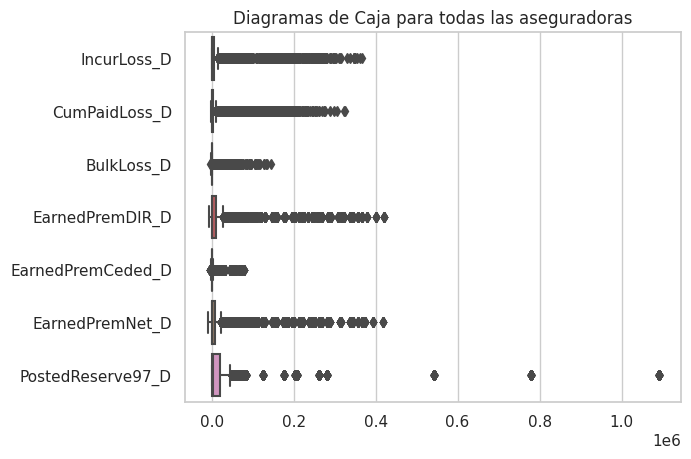

In [ ]:
# Boxplots de las variables númericas
sns.set(style="whitegrid")  # Estilo del gráfico
# se filtraron los datos por las columnas de reservas, pérdidas y primas
data_box = data.drop(columns=['GRCODE', 'AccidentYear', 'DevelopmentYear','DevelopmentLag', 'Single'])
sns.boxplot(data=data_box, orient="h") # Boxplots
plt.title("Diagramas de Caja para todas las aseguradoras")
plt.show()

De las anteriores estadísticas descriptivas y los gráficos de boxplot podemos concluir que los datos de las reservas se encuentran bastante dispersos, lo cual se justifica debido a la discrepancia de tamaño entre las aseguradoras.

In [ ]:
# Aseguradoras con reservas superiores a los $100 mil dólares
data.loc[data['PostedReserve97_D']>100000,'GRNAME'].unique()

array(['Allstate Ins Co Grp', 'California Cas Grp', 'Federal Ins Co Grp',
       'State Farm Mut Grp', 'Erie Ins Exchange Grp',
       'Pennsylvania Natl Ins Grp', 'New Jersey Manufacturers Grp',
       'Lumbermens Underwriting Alliance', 'Beacon Mut Ins Co'],
      dtype=object)

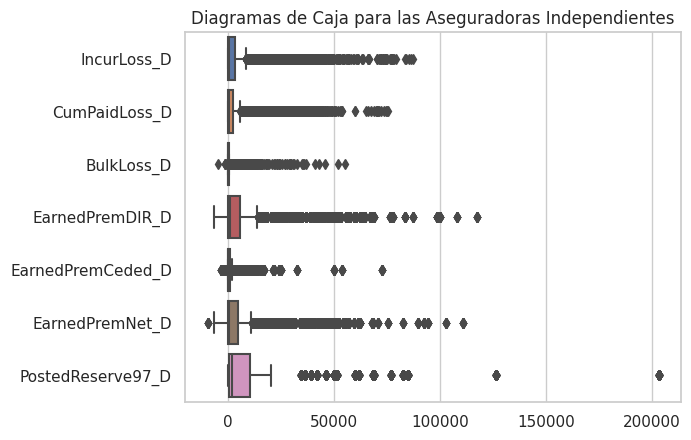

In [ ]:
# Boxplots de las variables númericas en Aseguradoras Independientes
sns.set(style="whitegrid")  # Estilo del gráfico
# se filtraron los datos por las columnas de reservas, pérdidas y primas
data_box2 = data.loc[data['Single']==1,].drop(columns=['GRCODE', 'AccidentYear',
                                                       'DevelopmentYear','DevelopmentLag', 'Single'])
sns.boxplot(data=data_box2, orient="h") # Boxplots
plt.title("Diagramas de Caja para las Aseguradoras Independientes")
plt.show()

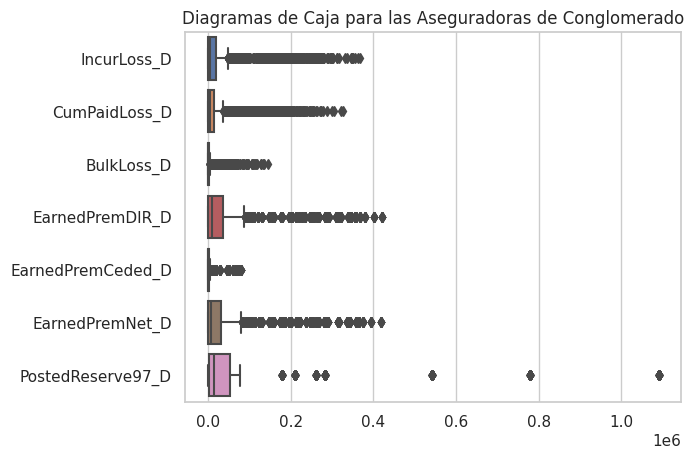

In [ ]:
# Boxplots de las variables númericas en Aseguradoras de Conglomerado
sns.set(style="whitegrid")  # Estilo del gráfico
# se filtraron los datos por las columnas de reservas, pérdidas y primas
data_box3 = data.loc[data['Single']==0,].drop(
    columns=['GRCODE', 'AccidentYear','DevelopmentYear','DevelopmentLag', 'Single'])

sns.boxplot(data=data_box3, orient="h") # Boxplots
plt.title("Diagramas de Caja para las Aseguradoras de Conglomerado")
plt.show()

Realizando los gráficos diferenciando entre las aseguradoras independientes y las que son parte de un conglomerado se observa que las dispersión entre los datos de las variables disminuye significativamente.

In [ ]:
data.columns

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremDIR_D',
       'EarnedPremCeded_D', 'EarnedPremNet_D', 'Single', 'PostedReserve97_D'],
      dtype='object')

Text(0.5, 1.0, 'Boxplot CumPaidLoss_D')

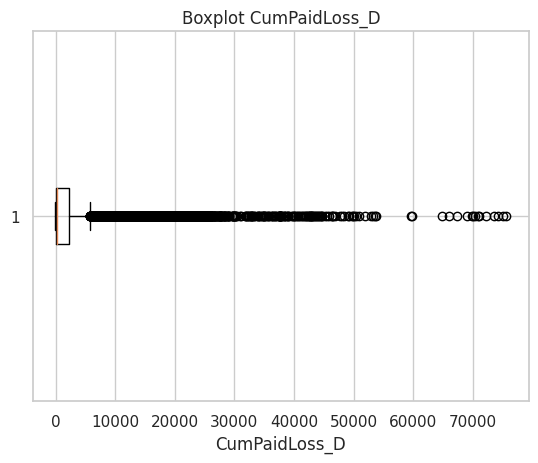

In [ ]:
# Boxplot por variable
name_column = 'CumPaidLoss_D' # nombre de la columna
plt.boxplot(data.loc[data['Single']==1,name_column], vert=False)
plt.xlabel(name_column)
#plt.ylabel('Valores')
plt.title(f'Boxplot {name_column}')

#### 2.3.3. Histogramas
Visualizaciones que ayuden a identificar patrones y relaciones.

In [ ]:
data_box.columns

Index(['GRNAME', 'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D',
       'EarnedPremDIR_D', 'EarnedPremCeded_D', 'EarnedPremNet_D',
       'PostedReserve97_D'],
      dtype='object')

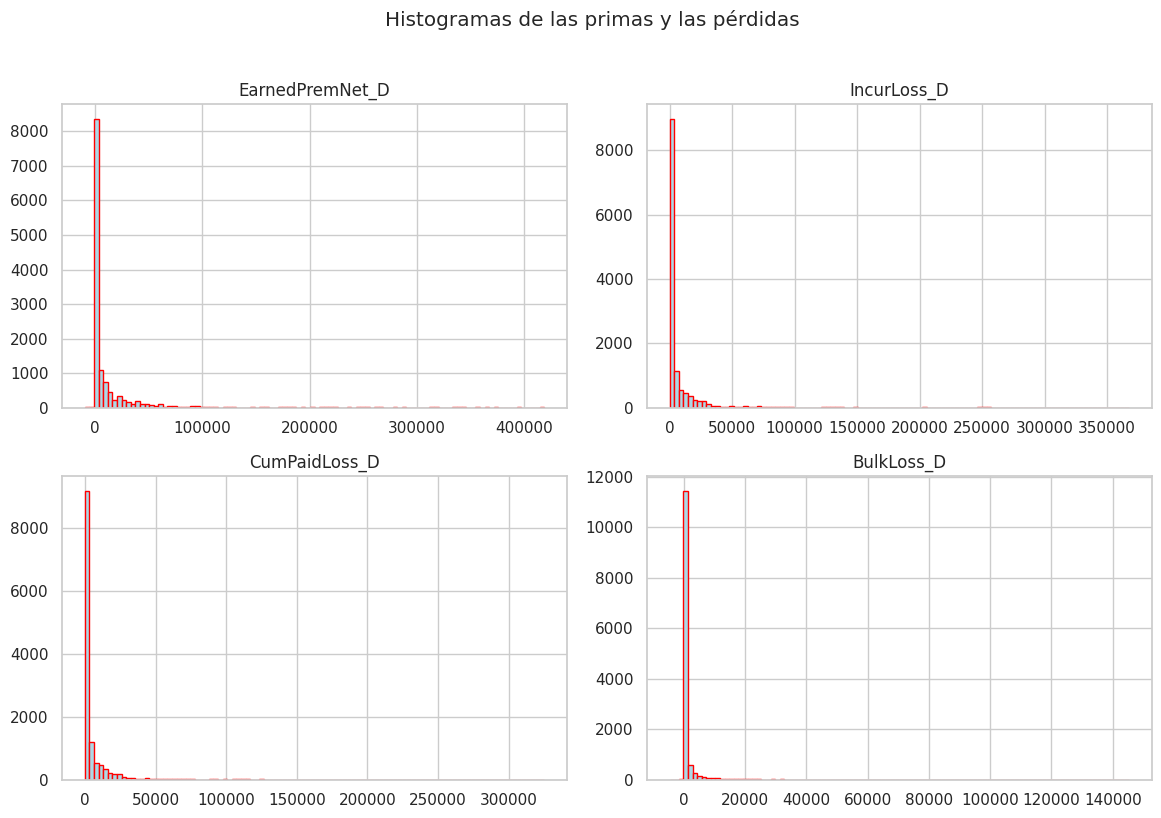

In [ ]:
data_box[['EarnedPremNet_D','IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D']].hist(figsize=(12, 8), bins=100,
                                                                                color = "lightblue", ec="red")
plt.suptitle("Histogramas de las primas y las pérdidas", y=1.02)
plt.tight_layout()
plt.show()

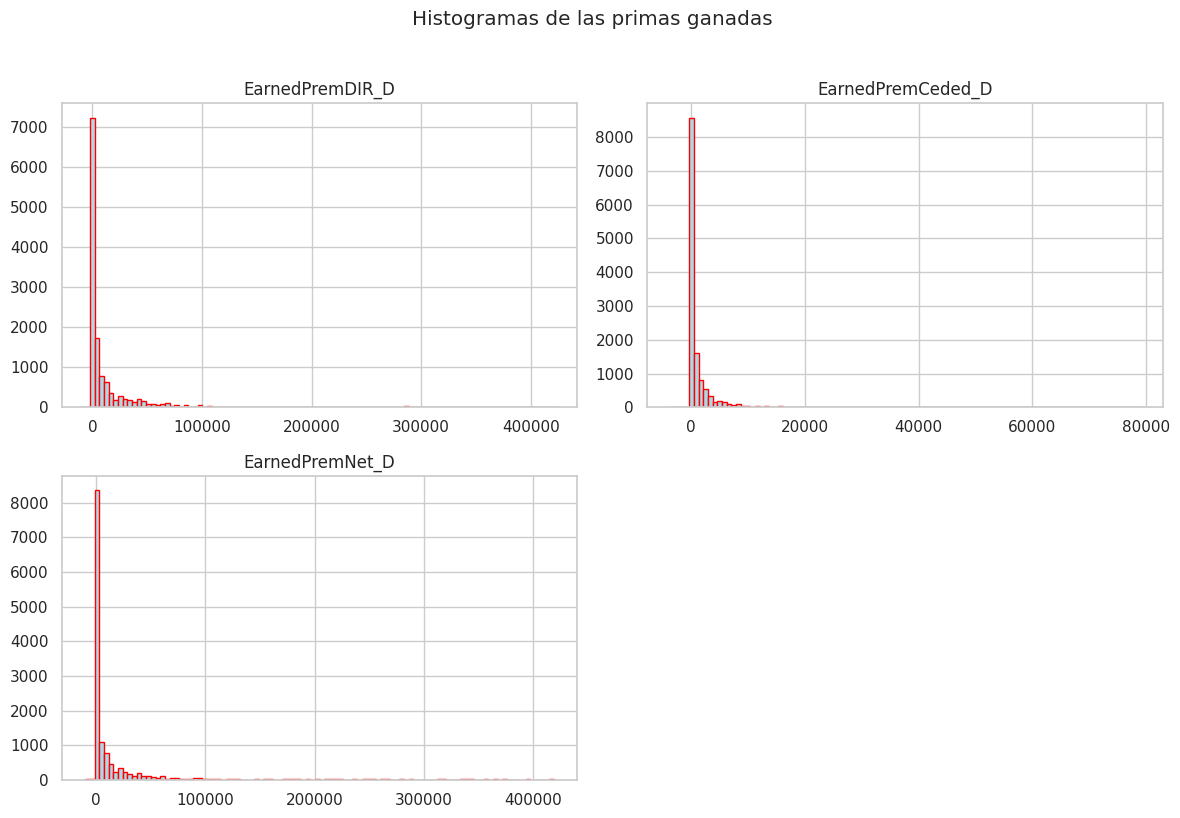

In [ ]:
data_box[['EarnedPremDIR_D', 'EarnedPremCeded_D', 'EarnedPremNet_D']].hist(figsize=(12, 8), bins=100,
                                                                                color = "lightblue", ec="red")
plt.suptitle("Histogramas de las primas ganadas", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
data.columns

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremDIR_D',
       'EarnedPremCeded_D', 'EarnedPremNet_D', 'Single', 'PostedReserve97_D'],
      dtype='object')

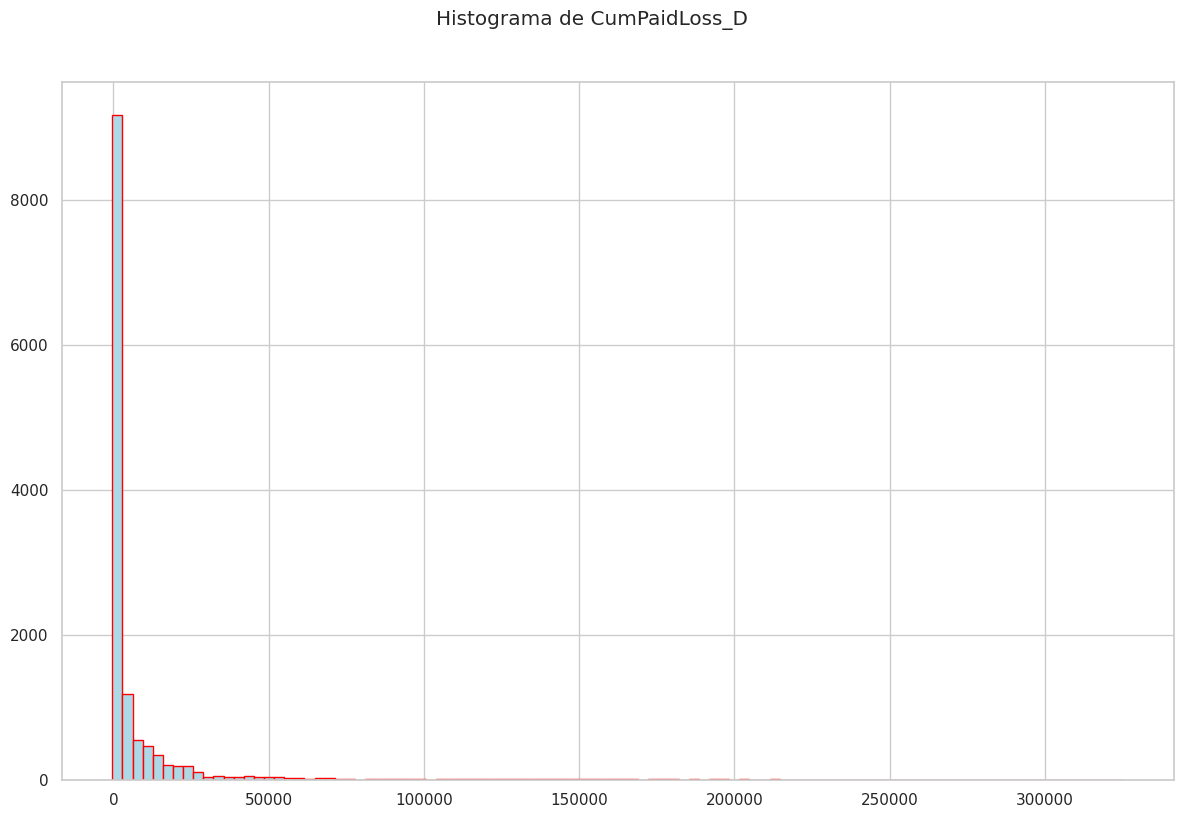

In [ ]:
# Histograma por columna
name_column = 'CumPaidLoss_D'
data_box[name_column].hist(figsize=(12, 8), bins=100, color = "lightblue", ec="red")
plt.suptitle(f'Histograma de {name_column}', y=1.02)
plt.tight_layout()
plt.show()

De estos gráficos podemos decir que todas las variables tienen una distribución sesgada a la derecha, por lo que para su modelamiento se pueden suponer distribuciones de probabilidad como la Pareto, Lognormal, Gamma o Weibull.  

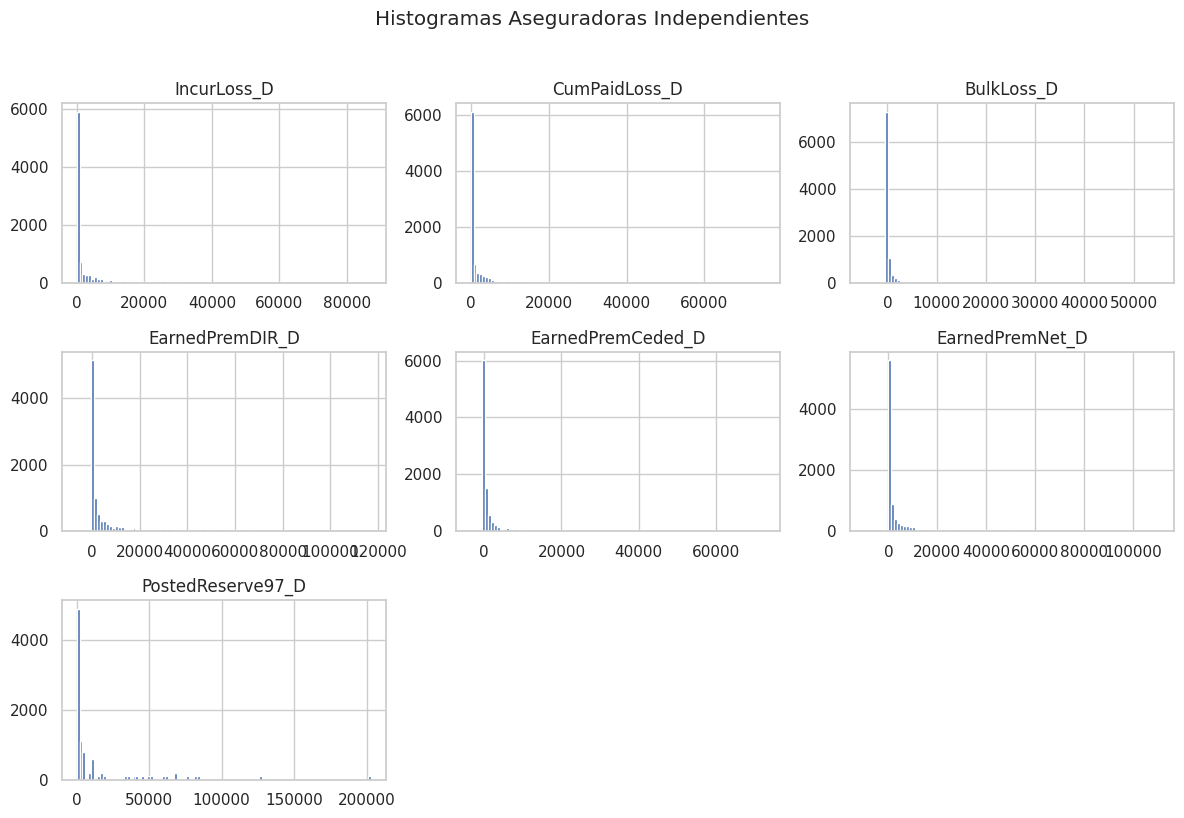

In [ ]:
data_box2.hist(figsize=(12, 8), bins=100)
plt.suptitle("Histogramas Aseguradoras Independientes", y=1.02)
plt.tight_layout()
plt.show()

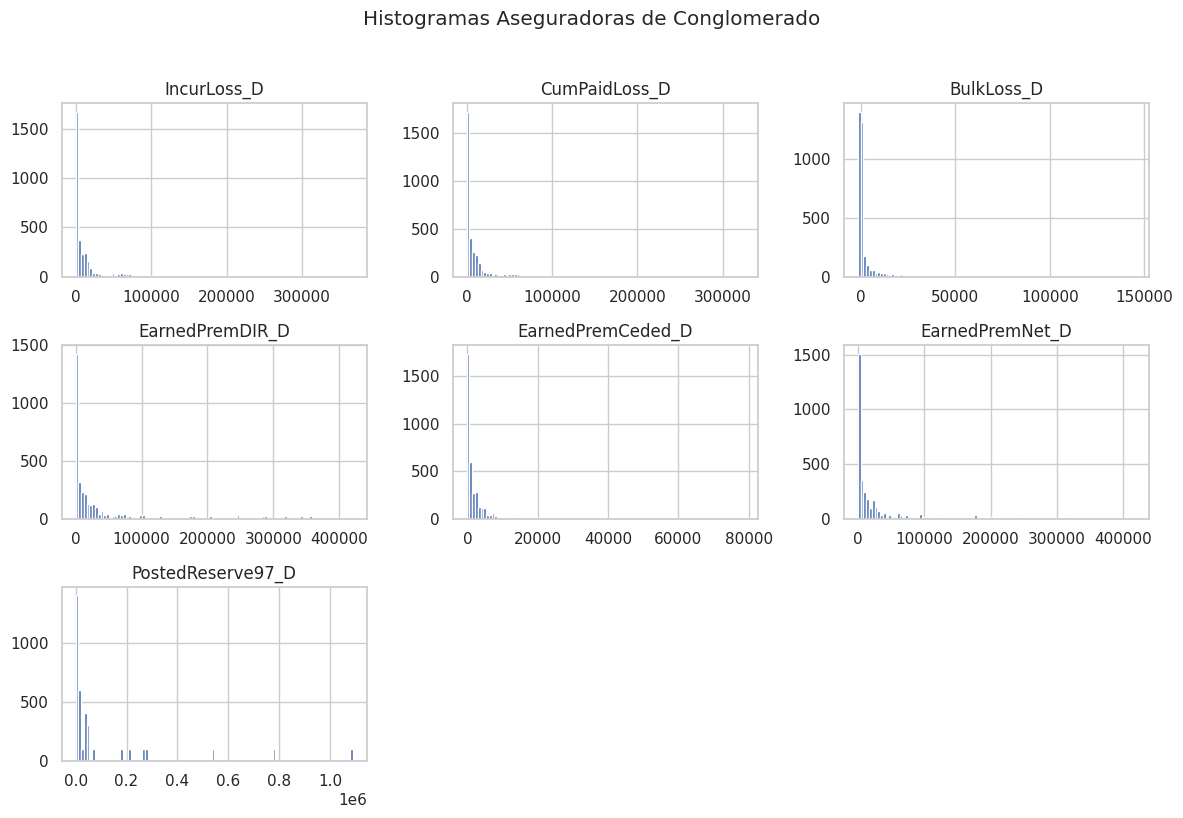

In [ ]:
data_box3.hist(figsize=(12, 8), bins=100)
plt.suptitle("Histogramas Aseguradoras de Conglomerado", y=1.02)
plt.tight_layout()
plt.show()

#### 2.3.4. Correlaciones entre las variables
Se analizan las relaciones entre diferentes variables para identificar posibles correlaciones o dependencias.

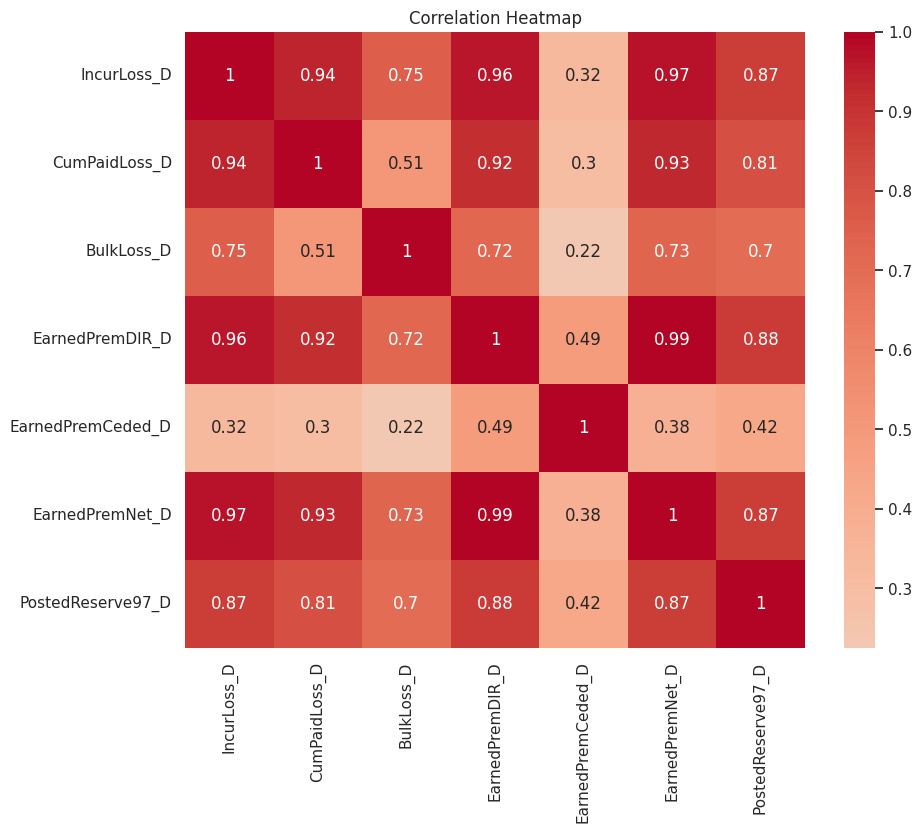

In [ ]:
# Calculation of the correlation matrix
correlation_matrix = data_box.corr()
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

De estos datos podemos concluir que hay una fuerte relación lineal entre las variables '*IncurLoss_D*', 'CumPaidLoss_D', 'EarnedPremDIR_D', 'EarnedPremNet_D' y 'PostedReserve97_D'. Es decir, hay una fuerte dependencia entre las Pérdidas incurridas, las pérdidas acumuladas pagadas, las primas gaandas y las reservas de las aseguradoras.

### 2.4. Verificar la calidad de los datos
Se evalúa la calidad de los datos en términos de integridad, consistencia y posibles problemas como valores faltantes o datos incorrectos.

#### 2.4.1. Valores faltantes

In [ ]:
# Validar si hay algun valor nulo o vacio en el data frame
nulos = data.isnull().any().sum()
print(f'Hay un total de {nulos} valores vacíos o nulos en la base de datos')

Hay un total de 0 valores vacíos o nulos en la base de datos


Por otro lado, de acuerdo a los gráficos anteriores observamos que hay una dispersión grande en los datos de todas las variables, distribuidos de forma asimétrica a la derecha, lo cual es justificado y tiene relación por la concentración de reclamaciones pequeñas y menos frecuentes reclamaciones grandes. Esto es común en seguros, donde un pequeño número de reclamaciones grandes puede tener un impacto significativo en las reservas.

### 2.5. Exploración de las estructuras de datos para el análisis (triángulos de run-off o de desarrollo)

Para el cálculo de reservas de siniestros en la industria de seguros una de las metodologías más usadas es el triángulo de desarollo. Un triángulo de desarrollo es una tabla que muestra cambios en el valor de varias cohortes de siniestros a través del tiempo (Fasecolda, 2022).

Para los ejemplos y el análisis desarrollado en está sección se trabajará con la variable **CumPaidLoss_D**, que como ya se había mencionado anteriormente corresponde a las pérdidas acumuladas pagadas y gastos asignados al final del año; lo cual representa la suma total de los pagos realizados por la aseguradora hasta ese momento para cubrir las reclamaciones y los costos asociados, incluyendo pagos realizados hasta el momento presente.

In [ ]:
data.columns

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremDIR_D',
       'EarnedPremCeded_D', 'EarnedPremNet_D', 'Single', 'PostedReserve97_D'],
      dtype='object')

In [ ]:
# Selected variable for analysis
variable = 'CumPaidLoss_D'

#### 2.5.1. Estadísticas descriptivas para la industria aseguradora

In [ ]:
# Summary info 'CumPaidLoss_D' for insurer companies
data_sum = data.groupby(['AccidentYear','DevelopmentLag'])[['IncurLoss_D', 'CumPaidLoss_D', 'EarnedPremNet_D', 'BulkLoss_D']].sum().reset_index()

# Run-off triangle cummulative
pivot_data_sum = pd.pivot_table(data_sum, values=variable, index=['AccidentYear'], columns='DevelopmentLag', aggfunc=np.sum, fill_value=0)
pivot_data_sum

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,285804,638532,865100,996363,1084351,1133188,1169749,1196917,1229203,1241715
1989,307720,684140,916996,1065674,1154072,1210479,1249886,1291512,1308706,1324671
1990,320124,757479,1017144,1169014,1258975,1315368,1368374,1394675,1417384,1431483
1991,347417,793749,1053414,1209556,1307164,1381645,1414747,1447121,1465508,1479177
1992,342982,781402,1014982,1172915,1281864,1328801,1370935,1399901,1419809,1437891
1993,342385,743433,959147,1113314,1187581,1243689,1278194,1301968,1322101,1337171
1994,351060,750392,993751,1114842,1193861,1243285,1276145,1302620,1321778,1340950
1995,343841,768575,962081,1087925,1164217,1210269,1243983,1264903,1282868,1300678
1996,381484,736040,937936,1056949,1131168,1182716,1218813,1239839,1260284,1274282


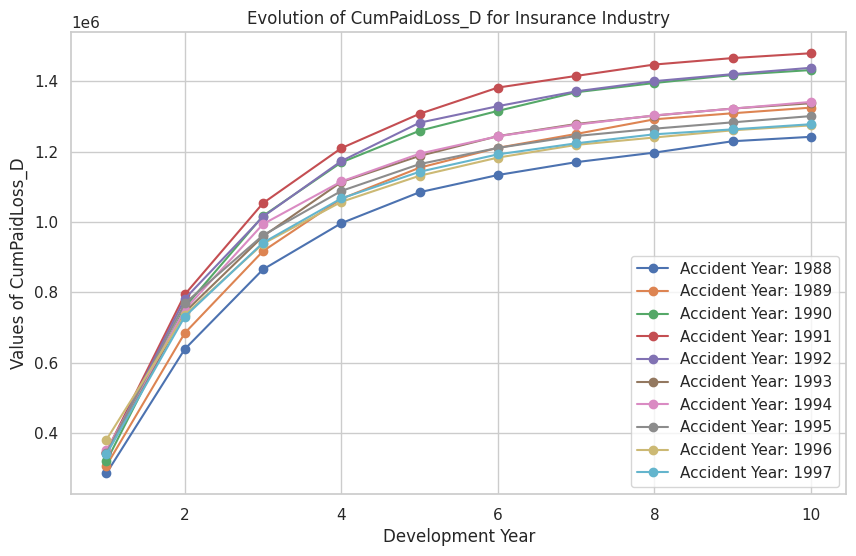

In [ ]:
# Evolution of claims payment for insurance industry
plt.figure(figsize=(10, 6))
for year in pivot_data_sum.index:
    plt.plot(pivot_data_sum.columns, pivot_data_sum.loc[year], marker='o', linestyle='-',label=f'Accident Year: {year}')

plt.title(f'Evolution of {variable} for Insurance Industry')
plt.xlabel('Development Year')
plt.ylabel(f'Values of {variable}')
plt.legend()
plt.grid(True)
plt.show()

#### 2.5.2. Estadísticas descriptivas - triángulos de desarrollo por aseguradora



In [ ]:
codes = data['GRCODE'].unique() # insurer codes
data.columns

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremDIR_D',
       'EarnedPremCeded_D', 'EarnedPremNet_D', 'Single', 'PostedReserve97_D'],
      dtype='object')

Triángulos de desarrollo completos

In [ ]:
triangles = triangles_function(data,codes,'CumPaidLoss_D')

Triangulos de desarrollo parte superior

In [ ]:
triangles_upper = triangles_upper_function(triangles)

Triangulos de desarrollo parte inferior

In [ ]:
triangles_lower = triangles_lower_function(triangles)

In [ ]:
triangles[86] # run-off triangle

DevelopmentLag          1       2       3       4       5       6       7   \
GRCODE AccidentYear                                                          
86     1988          70571  155905  220744  251595  274156  287676  298499   
       1989          66547  136447  179142  211343  231430  244750  254557   
       1990          52233  133370  178444  204442  222193  232940  253337   
       1991          59315  128051  169793  196685  213165  234676  239195   
       1992          39991   89873  114117  133003  154362  159496  164013   
       1993          19744   47229   61909   85099   87215   88602   89444   
       1994          20379   46773   88636   91077   92583   93346   93897   
       1995          18756   84712   87311   89200   90001   90247   90687   
       1996          42609   44916   46981   47899   48583   49109   49442   
       1997            691    2085    2795    2866    2905    2909    2908   

DevelopmentLag           8       9       10  
GRCODE AccidentYear                          
86     1988          304873  321808  325322  
       1989          270059  273873  277574  
       1990          256788  261166  263000  
       1991          245499  247131  248319  
       1992          166212  167397  168844  
       1993           89899   90446   90686  
       1994           94165   94558   94730  
       1995           91068   91001   91161  
       1996           49073   49161   49255  
       1997            2909    2909    2909

In [ ]:
triangles_lower[86] # example for a company

DevelopmentLag       1       2        3        4        5        6         7   \
GRCODE AccidentYear                                                             
86     1988         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1989         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1990         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1991         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1992         NaN     NaN      NaN      NaN      NaN      NaN  164013.0   
       1993         NaN     NaN      NaN      NaN      NaN  88602.0   89444.0   
       1994         NaN     NaN      NaN      NaN  92583.0  93346.0   93897.0   
       1995         NaN     NaN      NaN  89200.0  90001.0  90247.0   90687.0   
       1996         NaN     NaN  46981.0  47899.0  48583.0  49109.0   49442.0   
       1997         NaN  2085.0   2795.0   2866.0   2905.0   2909.0    2908.0   

DevelopmentLag             8         9         10  
GRCODE AccidentYear                                
86     1988               NaN       NaN       NaN  
       1989               NaN       NaN  277574.0  
       1990               NaN  261166.0  263000.0  
       1991          245499.0  247131.0  248319.0  
       1992          166212.0  167397.0  168844.0  
       1993           89899.0   90446.0   90686.0  
       1994           94165.0   94558.0   94730.0  
       1995           91068.0   91001.0   91161.0  
       1996           49073.0   49161.0   49255.0  
       1997            2909.0    2909.0    2909.0

In [ ]:
triangles_upper[86] # example for a company

DevelopmentLag          1         2         3         4         5         6   \
GRCODE AccidentYear                                                            
86     1988          70571  155905.0  220744.0  251595.0  274156.0  287676.0   
       1989          66547  136447.0  179142.0  211343.0  231430.0  244750.0   
       1990          52233  133370.0  178444.0  204442.0  222193.0  232940.0   
       1991          59315  128051.0  169793.0  196685.0  213165.0  234676.0   
       1992          39991   89873.0  114117.0  133003.0  154362.0  159496.0   
       1993          19744   47229.0   61909.0   85099.0   87215.0       NaN   
       1994          20379   46773.0   88636.0   91077.0       NaN       NaN   
       1995          18756   84712.0   87311.0       NaN       NaN       NaN   
       1996          42609   44916.0       NaN       NaN       NaN       NaN   
       1997            691       NaN       NaN       NaN       NaN       NaN   

DevelopmentLag             7         8         9         10  
GRCODE AccidentYear                                          
86     1988          298499.0  304873.0  321808.0  325322.0  
       1989          254557.0  270059.0  273873.0       NaN  
       1990          253337.0  256788.0       NaN       NaN  
       1991          239195.0       NaN       NaN       NaN  
       1992               NaN       NaN       NaN       NaN  
       1993               NaN       NaN       NaN       NaN  
       1994               NaN       NaN       NaN       NaN  
       1995               NaN       NaN       NaN       NaN  
       1996               NaN       NaN       NaN       NaN  
       1997               NaN       NaN       NaN       NaN

In [ ]:
df = pd.DataFrame(triangles[86])
df.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64', name='DevelopmentLag')

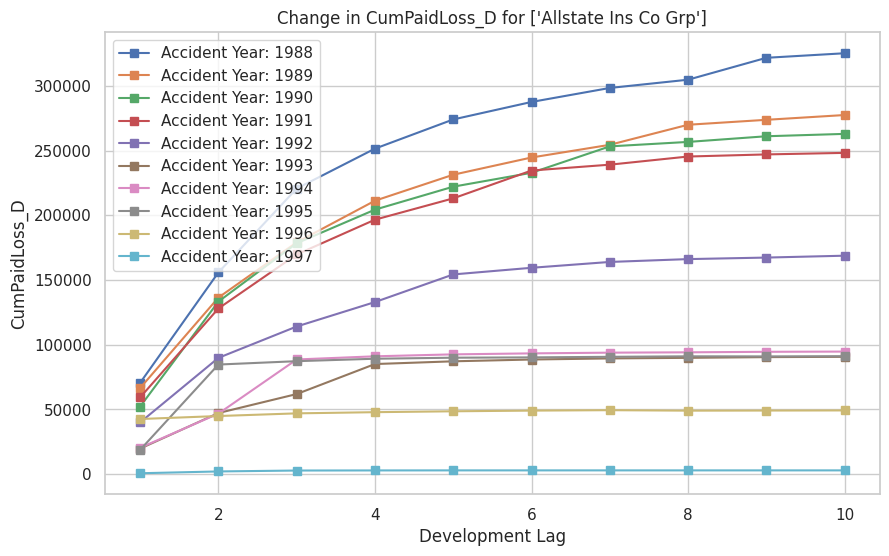

In [ ]:
code = 86 # insurance company code
name_company = data.loc[(data['GRCODE']==code),'GRNAME'].unique().astype(str)
years = [1988,1989,1990,1991,1992,1993,1994,1995,1996,1997] # year specific
plt.figure(figsize=(10, 6))
for year in years:
    triangle_year = triangles[code].xs(year, level=1)
    codes_insur = triangle_year.index.get_level_values(0).unique()
    datos_aseguradora = triangle_year.loc[code]
    years_later = datos_aseguradora.index.tolist()
    pagos_reclamaciones = datos_aseguradora.tolist()
    plt.plot(years_later, pagos_reclamaciones, marker='s', linestyle='-', label=f'Accident Year: {year}')

plt.title(f'Change in {variable} for {name_company}')
plt.xlabel('Development Lag')
plt.ylabel(f'{variable}')
plt.legend()
plt.grid(True)

# show plot
plt.show()

## 3.- Preparación de los datos

### 3.1. Seleccionar los datos
Se quiere realizar un modelo de predicción de las reservas que debería tener una aseguradora de la línea de seguros de compensación laboral, siguiendo la metodología de Chain Ladder con triángulos de desarrollo con aprendizaje de maquinas para predecir el monto de las reclamaciones futuras. Para este propósito se trabajará con las  siguientes variables del conjunto de datos:
+ Línea de negocio (*'Single'*): Indica si se trata de una entidad única (1) o una aseguradora de grupo (0). Esto puede ser relevante para considerar la estructura de la empresa aseguradora.
+ Código de empresa(*'GRCODE'*)
+ Año del accidente (*'AccidentYear'*): El año en que ocurrió el evento o accidente que dio lugar a la reclamación.
+ Retraso en el desarrollo (*'DevelopmentLag'*): Representa cuántos años han pasado desde el año de ocurrencia del evento hasta el año actual. Esta variable es fundamental para construir los triángulos de desarrollo.
+ Pérdida incurrida (*'IncurLoss_D'*): Pérdidas incurridas y gastos asignados reportados al final del año. Esta cifra es una parte importante en la evaluación de la cantidad total de dinero que la aseguradora espera gastar para cubrir las reclamaciones y los costos asociados en ese año específico.
+ Pérdida pagada acumulada (*'CumPaidLoss_D'*): El monto acumulado pagado en reclamaciones hasta el año de desarrollo correspondiente. Este es un valor crítico para calcular las reservas.
+ IBNR (*'BulkLoss'*): Las reservas a granel y los gastos de defensa y costos de contención reportados al final del año. Esto puede ser relevante para tener en cuenta costos adicionales asociados a las reclamaciones.
+ Prima neta ganada (*'EarnedPremNet_D'*): Las primas devengadas en el año de ocurrencia del evento. Lo cual se utilizará para calcular las tasas de siniestralidad y es relevante para determinar la relación entre las pérdidas y las primas.
+ Reservas publicadas (*'PostedReserve97_D'*): Las reservas publicadas en un año específico. Esto puede utilizarse como referencia para comparar con las estimaciones del modelo.

In [ ]:
#data.groupby(['AccidentYear','DevelopmentLag'])[['IncurLoss_D','CumPaidLoss_D',
#                                                 'BulkLoss_D','EarnedPremNet_D',
#                                                 'PostedReserve97_D']].sum().reset_index().describe().drop(columns=['AccidentYear','DevelopmentLag'])
data[['IncurLoss_D','CumPaidLoss_D','BulkLoss_D','EarnedPremNet_D','PostedReserve97_D']].describe()

,IncurLoss_D,CumPaidLoss_D,BulkLoss_D,EarnedPremNet_D,PostedReserve97_D
count,13200.000000,13200.000000,13200.000000,13200.000000,1.320000e+04
mean,11532.048258,8215.737348,1570.125606,16626.128788,3.971440e+04
std,35595.560208,25714.081464,7259.022141,48941.724122,1.301307e+05
min,-59.000000,-338.000000,-4621.000000,-9731.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,4.110000e+02
50%,544.000000,351.500000,5.000000,827.000000,2.732000e+03
75%,6526.500000,4565.000000,259.250000,9180.500000,1.926575e+04
max,367404.000000,325322.000000,145296.000000,418755.000000,1.090093e+06


In [ ]:
# Data selection for model training
type_company = 1 # 1 for single y 0 groups
subset = data[data['Single']==type_company]
variables = ['GRCODE', 'AccidentYear', 'DevelopmentLag', 'IncurLoss_D',
             'CumPaidLoss_D', 'BulkLoss_D','EarnedPremNet_D', 'PostedReserve97_D']
subset = subset[variables]
subset.head(10)

,GRCODE,AccidentYear,DevelopmentLag,IncurLoss_D,CumPaidLoss_D,BulkLoss_D,EarnedPremNet_D,PostedReserve97_D
3600,10011,1988,1,0,0,0,0,8967
3601,10011,1988,2,0,0,0,0,8967
3602,10011,1988,3,0,0,0,0,8967
3603,10011,1988,4,0,0,0,0,8967
3604,10011,1988,5,0,0,0,0,8967
3605,10011,1988,6,0,0,0,0,8967
3606,10011,1988,7,0,0,0,0,8967
3607,10011,1988,8,0,0,0,0,8967
3608,10011,1988,9,0,0,0,0,8967
3609,10011,1988,10,0,0,0,0,8967


### 3.2. Limpieza de los datos y construcción de los triangulos de desarrollo
Las reclamaciones pendientes, a los efectos de este modelo, se derivan de la pérdida incurrida menos la pérdida pagada acumulada. El código de empresa es una variable categórica que indica a qué aseguradora están asociados los registros.

In [ ]:
variables = ['IncurLoss_D', 'CumPaidLoss_D', 'BulkLoss_D', 'EarnedPremNet_D']
variable = variables[1]
print(f'La variable seleccionada para el modelo es "{variable}"')

La variable seleccionada para el modelo es "CumPaidLoss_D"


In [ ]:
# A dictionary created with the run-off triangles of the insurers
# run-off triangles complete
codes = data['GRCODE'].unique() # insurer codes
triangles = triangles_function(data, codes, variable)

Para algunas aseguradoras se tienen ceros en algunos años de desarrollo. Para evitar errores en el modelo y para el caso de aplicación del modelo de chain ladder determinístico se quitaran estas aseguradoras.

In [ ]:
triangles_filtered = triangles_filtered_function(triangles)
print(f'Sacando las aseguradoras que tienen algunos años en ceros quedamos con un total de {len(triangles_filtered)}  aseguradoras para el análisis.')

Sacando las aseguradoras que tienen algunos años en ceros quedamos con un total de 59  aseguradoras para el análisis.


In [ ]:
codes = list(triangles_filtered.keys())

In [ ]:
# Upper triangles
triangles_upper_filtered = triangles_upper_function(triangles_filtered)
triangles_upper_filtered[86] # example for a company

DevelopmentLag          1         2         3         4         5         6   \
GRCODE AccidentYear                                                            
86     1988          70571  155905.0  220744.0  251595.0  274156.0  287676.0   
       1989          66547  136447.0  179142.0  211343.0  231430.0  244750.0   
       1990          52233  133370.0  178444.0  204442.0  222193.0  232940.0   
       1991          59315  128051.0  169793.0  196685.0  213165.0  234676.0   
       1992          39991   89873.0  114117.0  133003.0  154362.0  159496.0   
       1993          19744   47229.0   61909.0   85099.0   87215.0       NaN   
       1994          20379   46773.0   88636.0   91077.0       NaN       NaN   
       1995          18756   84712.0   87311.0       NaN       NaN       NaN   
       1996          42609   44916.0       NaN       NaN       NaN       NaN   
       1997            691       NaN       NaN       NaN       NaN       NaN   

DevelopmentLag             7         8         9         10  
GRCODE AccidentYear                                          
86     1988          298499.0  304873.0  321808.0  325322.0  
       1989          254557.0  270059.0  273873.0       NaN  
       1990          253337.0  256788.0       NaN       NaN  
       1991          239195.0       NaN       NaN       NaN  
       1992               NaN       NaN       NaN       NaN  
       1993               NaN       NaN       NaN       NaN  
       1994               NaN       NaN       NaN       NaN  
       1995               NaN       NaN       NaN       NaN  
       1996               NaN       NaN       NaN       NaN  
       1997               NaN       NaN       NaN       NaN

## 4.- Modelación

* Modeling overview
* Selecting Modeling Techniques
  * Chosing the right modeling Techniques
  * Modeling assumptions
* Generating a test desing
* Building the model
* Assesing the model - performance

{Responder las preguntas dde la presentación (foto celular)}

### 4.1. Chain ladder determinístico




In [ ]:
predict_triangles = chain_ladder_deterministico(triangles_upper_filtered)

In [ ]:
print('Tamaño de la muestra para el experimento Chain Ladder Determinístico:')
print(f'>>> {len(triangles_upper_filtered)} aseguradoras')

Tamaño de la muestra para el experimento Chain Ladder Determinístico:
>>> 59 aseguradoras


In [ ]:
triangles_filtered[86]

DevelopmentLag          1       2       3       4       5       6       7   \
GRCODE AccidentYear                                                          
86     1988          70571  155905  220744  251595  274156  287676  298499   
       1989          66547  136447  179142  211343  231430  244750  254557   
       1990          52233  133370  178444  204442  222193  232940  253337   
       1991          59315  128051  169793  196685  213165  234676  239195   
       1992          39991   89873  114117  133003  154362  159496  164013   
       1993          19744   47229   61909   85099   87215   88602   89444   
       1994          20379   46773   88636   91077   92583   93346   93897   
       1995          18756   84712   87311   89200   90001   90247   90687   
       1996          42609   44916   46981   47899   48583   49109   49442   
       1997            691    2085    2795    2866    2905    2909    2908   

DevelopmentLag           8       9       10  
GRCODE AccidentYear                          
86     1988          304873  321808  325322  
       1989          270059  273873  277574  
       1990          256788  261166  263000  
       1991          245499  247131  248319  
       1992          166212  167397  168844  
       1993           89899   90446   90686  
       1994           94165   94558   94730  
       1995           91068   91001   91161  
       1996           49073   49161   49255  
       1997            2909    2909    2909

In [ ]:
predict_triangles[86]

DevelopmentLag          1              2              3              4   \
GRCODE AccidentYear                                                       
86     1988          70571  155905.000000  220744.000000  251595.000000   
       1989          66547  136447.000000  179142.000000  211343.000000   
       1990          52233  133370.000000  178444.000000  204442.000000   
       1991          59315  128051.000000  169793.000000  196685.000000   
       1992          39991   89873.000000  114117.000000  133003.000000   
       1993          19744   47229.000000   61909.000000   85099.000000   
       1994          20379   46773.000000   88636.000000   91077.000000   
       1995          18756   84712.000000   87311.000000  101143.981086   
       1996          42609   44916.000000   60085.500190   69605.051995   
       1997            691    1536.064068    2054.839654    2380.394945   

DevelopmentLag                  5              6              7   \
GRCODE AccidentYear                                                
86     1988          274156.000000  287676.000000  298499.000000   
       1989          231430.000000  244750.000000  254557.000000   
       1990          222193.000000  232940.000000  253337.000000   
       1991          213165.000000  234676.000000  239195.000000   
       1992          154362.000000  159496.000000  166760.099724   
       1993           87215.000000   92329.546875   96534.611805   
       1994           99522.961906  105359.284257  110157.776681   
       1995          110523.497443  117004.923901  122333.806352   
       1996           76059.827818   80520.202234   84187.421342   
       1997            2601.139206    2753.677742    2879.091481   

DevelopmentLag                  8              9              10  
GRCODE AccidentYear                                               
86     1988          304873.000000  321808.000000  325322.000000  
       1989          270059.000000  273873.000000  276863.571154  
       1990          256788.000000  266055.346768  268960.552632  
       1991          246707.579803  255611.129394  258402.289056  
       1992          171997.661366  178204.968449  180150.887317  
       1993           99566.547986  103159.853463  104286.313106  
       1994          113617.585993  117717.986200  119003.414168  
       1995          126176.037514  130729.665773  132157.175486  
       1996           86831.559895   89965.266205   90947.646834  
       1997            2969.517303    3076.685654    3110.281691

In [ ]:
# Lower triangles original
triangles_lower_original = triangles_lower_function(triangles_filtered)
# predicted triangles
triangles_lower_predicted = triangles_lower_function(predict_triangles)

In [ ]:
# Example of lower triangle with original data
triangles_lower_original[86]

DevelopmentLag       1       2        3        4        5        6         7   \
GRCODE AccidentYear                                                             
86     1988         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1989         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1990         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1991         NaN     NaN      NaN      NaN      NaN      NaN       NaN   
       1992         NaN     NaN      NaN      NaN      NaN      NaN  164013.0   
       1993         NaN     NaN      NaN      NaN      NaN  88602.0   89444.0   
       1994         NaN     NaN      NaN      NaN  92583.0  93346.0   93897.0   
       1995         NaN     NaN      NaN  89200.0  90001.0  90247.0   90687.0   
       1996         NaN     NaN  46981.0  47899.0  48583.0  49109.0   49442.0   
       1997         NaN  2085.0   2795.0   2866.0   2905.0   2909.0    2908.0   

DevelopmentLag             8         9         10  
GRCODE AccidentYear                                
86     1988               NaN       NaN       NaN  
       1989               NaN       NaN  277574.0  
       1990               NaN  261166.0  263000.0  
       1991          245499.0  247131.0  248319.0  
       1992          166212.0  167397.0  168844.0  
       1993           89899.0   90446.0   90686.0  
       1994           94165.0   94558.0   94730.0  
       1995           91068.0   91001.0   91161.0  
       1996           49073.0   49161.0   49255.0  
       1997            2909.0    2909.0    2909.0

In [ ]:
# Example of lower triangle with predicted data
triangles_lower_predicted[86]

DevelopmentLag       1            2             3              4   \
GRCODE AccidentYear                                                 
86     1988         NaN          NaN           NaN            NaN   
       1989         NaN          NaN           NaN            NaN   
       1990         NaN          NaN           NaN            NaN   
       1991         NaN          NaN           NaN            NaN   
       1992         NaN          NaN           NaN            NaN   
       1993         NaN          NaN           NaN            NaN   
       1994         NaN          NaN           NaN            NaN   
       1995         NaN          NaN           NaN  101143.981086   
       1996         NaN          NaN  60085.500190   69605.051995   
       1997         NaN  1536.064068   2054.839654    2380.394945   

DevelopmentLag                  5              6              7   \
GRCODE AccidentYear                                                
86     1988                    NaN            NaN            NaN   
       1989                    NaN            NaN            NaN   
       1990                    NaN            NaN            NaN   
       1991                    NaN            NaN            NaN   
       1992                    NaN            NaN  166760.099724   
       1993                    NaN   92329.546875   96534.611805   
       1994           99522.961906  105359.284257  110157.776681   
       1995          110523.497443  117004.923901  122333.806352   
       1996           76059.827818   80520.202234   84187.421342   
       1997            2601.139206    2753.677742    2879.091481   

DevelopmentLag                  8              9              10  
GRCODE AccidentYear                                               
86     1988                    NaN            NaN            NaN  
       1989                    NaN            NaN  276863.571154  
       1990                    NaN  266055.346768  268960.552632  
       1991          246707.579803  255611.129394  258402.289056  
       1992          171997.661366  178204.968449  180150.887317  
       1993           99566.547986  103159.853463  104286.313106  
       1994          113617.585993  117717.986200  119003.414168  
       1995          126176.037514  130729.665773  132157.175486  
       1996           86831.559895   89965.266205   90947.646834  
       1997            2969.517303    3076.685654    3110.281691

### 4.2. Métrica de desempeño
Se utilizaran las siguientes medidas de desempeño para evaluar el modelo sobre la industria aseguradora. Se proponen dos enfoques para este análisis: uno, las métricas de desempeño de cada aseguradora y una métrica ponderada para el desempeño del modelo en toda la industria.

+ Error Cuadrático Medio (MSE - Mean Squared Error): El MSE mide el promedio de los errores al cuadrado entre las predicciones del modelo y los valores reales.

  Fórmula: $$ MSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

  Donde yi son los valores reales, ŷi son las predicciones del modelo, y n es el número de observaciones.

+ Porcentaje de Error Absoluto Promedio (MAPE - Mean Absolute Percentage Error): El MAPE mide la precisión de un modelo o un método de pronóstico al calcular el porcentaje promedio de error absoluto en relación con los valores reales. Esta métrica es útil para evaluar qué tan cerca están las predicciones del modelo de los valores reales en términos porcentuales.
  Fórmula: $$ MAPE = \frac{1}{n} \sum_{i=1}^{n} \frac{|Y_i - \hat{Y}_i|}{|Y_i|} \times 100\% $$
  
  Donde yi son los valores reales, ŷi son las predicciones del modelo, y n es el número de observaciones.


In [ ]:
print(f'El MAPE del experimento Chain Ladder Determinístico es {round(performance_MAPE_function(triangles_lower_original, triangles_lower_predicted),4)}%')

El MAPE del experimento Chain Ladder Determinístico es 10.6744%


El Porcentaje de Error Absoluto Promedio del modelo Chain Ladder Determinístico es 10.6744%.
 
El comportamiento de la métrica de desempeño MAPE para el grupo de aseguradoras con Chain Ladder Determinístico:
 


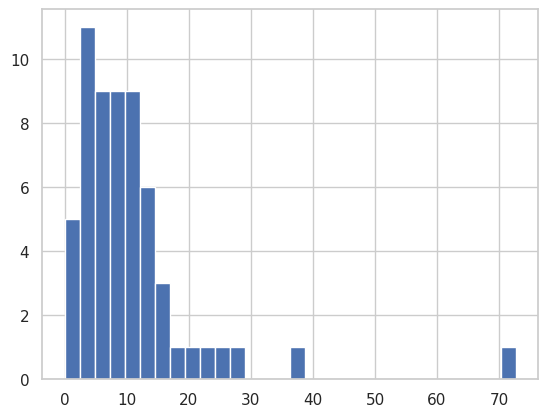

In [ ]:
performance_result_function('Chain Ladder Determinístico', triangles_lower_original, triangles_lower_predicted)

In [ ]:
mse_chainladder = performance_chain_function(triangles_lower_original, triangles_lower_predicted)
mse_chainladder = mse_chainladder[['Insurer Company', 'MAPE']]
mse_chainladder.columns = ['code', 'MSE_ChainLadder']
mse_chainladder

,code,MSE_ChainLadder
0,86,20.091369
1,337,2.657980
2,353,16.811936
3,388,8.432703
4,671,1.257895
5,715,1.550136
6,965,8.297465
7,1066,12.348233
8,1252,9.301804
9,1538,3.973560


### 4.3. Diseño del experimento - Modelo de Regresión
Modelo de machine learning

In [ ]:
codes = codes_function(data, 'All')
triangles_rg = triangles_function(data, codes, 'IncurLoss_D')
triangles_rg = triangles_function(data, codes, 'CumPaidLoss_D')

In [ ]:
codes = codes_function(data, 'All')
triangles_rg = triangles_filtered_function(triangles_function(data, codes, 'IncurLoss_D')) # run-off triangles complete
tr_up_rg = triangles_upper_function(triangles_rg) # upper triangles
print(f'Tamaño muestral: {len(triangles_rg)} aseguradoras')
# print(' ')
# print(tr_up_rg[list(tr_up_rg.keys())[0]]) # print first element

Tamaño muestral: 62 aseguradoras


In [ ]:
def chain_ladder_linear(triangles_uppers):
  '''
  Function definition:
    This function return the predicted run-off triangle with chain
    ladder linear method.

  Input:
    triangles_uppers: "A Dictionary with upper run-off triangles."

  Output:
    A dictionary with predicted run-off triangles with Chain Ladder
    Linear Model.
  '''
  predict_triangles = {}
  codes = list(triangles_uppers.keys())
  for code in codes:
    predict_triangle = triangles_uppers[code]
    for row in range(predict_triangle.shape[0]):
      for column in range(predict_triangle.shape[1]):
        if np.isnan(predict_triangle.iloc[row, column]):
          dev_factor = predict_triangle.iloc[0:row, column].sum() / predict_triangle.iloc[0:row, column-1].sum()
          predict_triangle.iloc[row, column] = predict_triangle.iloc[row, column-1]*dev_factor

    predict_triangles[code] = predict_triangle

  return predict_triangles

In [ ]:
codes = codes_function(data,'All') # selección de los códigos del data original
triangles = triangles_function(data, codes, 'IncurLoss_D') # se construyen los cuadros completos
triangles_filtered = triangles_filtered_function(triangles) # se filtran los triangulos sin ceros
triangles_upper_filtered = triangles_upper_function(triangles_filtered) # se toma el triangulo superior
triangles_lower_filtered = triangles_lower_function(triangles_filtered) # se toma el triangulo inferior

In [ ]:
n_dim = triangles_upper_filtered[list(triangles_upper_filtered.keys())[0]].shape[0] # dimensions number
n_data = n_dim**2 # data in every matrix
n_data_upside = int((n_data-n_dim)/2+n_dim) # data in upper triangles
n_parameters = n_dim*2-1 # parameters number to regression model

zeros_matrix =  np.zeros((n_data, n_parameters)) # zeros matrix
zeros_matrix[:,0] = 1 # column to intercept model (miu)
for col in range(n_dim):
  for row in range(n_dim):
    row_p = col*n_dim+row
    if col != 0:
      zeros_matrix[row_p,col] = 1
    if row != 0:
      zeros_matrix[row_p,row+n_dim-1] = 1

zeros_matrix = pd.DataFrame(zeros_matrix)

In [ ]:
zeros_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
97,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
98,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 4.4. Modelos

In [ ]:
# Normal Linear regresion
def linear_regression_model_function(code):
  '''
    This function fit a regression model over a run-off triangle

    Input:
      A number of insurer code

    Output:
      model: a linear regression model
      mse: mean squared error of the model
  '''

  df_trg_entreno = triangulo(data, grcode=code, entreno=True) # Upper triangle
  df_trg_prueba  = triangulo(data, grcode=code, entreno=False) # Triangles complete data

  Y = matrix_y(df_trg_entreno) # vector Y - datos conocidos
  X = matrix_X(df_trg_entreno) # parametros

  Y_X = pd.merge(Y, X, on='y_ii', how='inner') #
  data_entreno = Y_X[Y_X['Y'].notna()]
  data_entreno = data_entreno.drop(['y_ii'], axis=1)

  Y_prueba = matrix_y(df_trg_prueba)
  x_prueba = Y_X[Y_X['Y'].isna()].drop(['Y'], axis=1)
  data_prueba_ = pd.merge(Y_prueba, x_prueba, on='y_ii', how='inner')
  data_prueba=data_prueba_.drop(['y_ii'], axis=1)
  y_ii = data_prueba_['y_ii']

  # Modelo de regresion
  x_entreno = data_entreno.drop('Y', axis=1)  # Features
  y_entreno = data_entreno['Y']  # Target variable
  x_prueba  = data_prueba.drop('Y', axis=1)  # Features
  y_prueba  = data_prueba['Y']  # Target variable

  model = LinearRegression()
  model.fit(x_entreno, y_entreno)
  coeficientes = model.coef_
  intersection = model.intercept_

  y_pred = model.predict(x_prueba)
  mse = mean_squared_error(y_prueba, y_pred)*100   # Considerar que se debe aplicar la exponencial a los resultados

  return model, mse

In [ ]:
# Ridge Linear regresion
def Ridge_regression_model_function(code, alpha):
  '''
    This function fit a regression model with ridge regularization
    over a run-off triangle

    Input:
      'code': A number of insurer code
      'alpha': a number of alpha parameter of ridge regulatization

    Output:
      model: a linear regression model
      mse: mean squared error of the model
  '''

  df_trg_entreno = triangulo(data, grcode=code, entreno=True) # Upper triangle
  df_trg_prueba  = triangulo(data, grcode=code, entreno=False) # Triangles complete data

  Y = matrix_y(df_trg_entreno) # vector Y - datos conocidos
  X = matrix_X(df_trg_entreno) # parametros

  Y_X = pd.merge(Y, X, on='y_ii', how='inner') #
  data_entreno = Y_X[Y_X['Y'].notna()]
  data_entreno = data_entreno.drop(['y_ii'], axis=1)

  Y_prueba = matrix_y(df_trg_prueba)
  x_prueba = Y_X[Y_X['Y'].isna()].drop(['Y'], axis=1)
  data_prueba_ = pd.merge(Y_prueba, x_prueba, on='y_ii', how='inner')
  data_prueba=data_prueba_.drop(['y_ii'], axis=1)
  y_ii = data_prueba_['y_ii']

  # Modelo de regresion
  x_entreno = data_entreno.drop('Y', axis=1)  # Features
  y_entreno = data_entreno['Y']  # Target variable
  x_prueba  = data_prueba.drop('Y', axis=1)  # Features
  y_prueba  = data_prueba['Y']  # Target variable

  model = Ridge(alpha)
  model.fit(x_entreno, y_entreno)
  coeficientes = model.coef_
  intersection = model.intercept_

  y_pred = model.predict(x_prueba)
  mse = mean_squared_error(y_prueba, y_pred)*100   # Considerar que se debe aplicar la exponencial a los resultados

  return model, mse

In [ ]:
# Lasson Linear regresion
def Lasso_regression_model_function(code, alpha):
  '''
    This function fit a regression model with lasso regularization
    over a run-off triangle

    Input:
      'code': A number of insurer code
      'alpha': a number of alpha parameter of lasso regulatization

    Output:
      model: a linear regression model
      mse: mean squared error of the model
  '''

  df_trg_entreno = triangulo(data, grcode=code, entreno=True) # Upper triangle
  df_trg_prueba  = triangulo(data, grcode=code, entreno=False) # Triangles complete data

  Y = matrix_y(df_trg_entreno) # vector Y - datos conocidos
  X = matrix_X(df_trg_entreno) # parametros

  Y_X = pd.merge(Y, X, on='y_ii', how='inner') #
  data_entreno = Y_X[Y_X['Y'].notna()]
  data_entreno = data_entreno.drop(['y_ii'], axis=1)

  Y_prueba = matrix_y(df_trg_prueba)
  x_prueba = Y_X[Y_X['Y'].isna()].drop(['Y'], axis=1)
  data_prueba_ = pd.merge(Y_prueba, x_prueba, on='y_ii', how='inner')
  data_prueba=data_prueba_.drop(['y_ii'], axis=1)
  y_ii = data_prueba_['y_ii']

  # Modelo de regresion
  x_entreno = data_entreno.drop('Y', axis=1)  # Features
  y_entreno = data_entreno['Y']  # Target variable
  x_prueba  = data_prueba.drop('Y', axis=1)  # Features
  y_prueba  = data_prueba['Y']  # Target variable

  model = Lasso(alpha)
  model.fit(x_entreno, y_entreno)
  coeficientes = model.coef_
  intersection = model.intercept_

  y_pred = model.predict(x_prueba)
  mse = mean_squared_error(y_prueba, y_pred)*100   # Considerar que se debe aplicar la exponencial a los resultados

  return model, mse

In [ ]:
def estructura_datos(data, code):
    df_trg_entreno = triangulo(data, grcode=code, entreno=True) # Upper triangle
    df_trg_prueba  = triangulo(data, grcode=code, entreno=False) # Triangles complete data
    Y = matrix_y(df_trg_entreno) # vector Y - datos conocidos
    X = matrix_X(df_trg_entreno) # parametros
    Y_X = pd.merge(Y, X, on='y_ii', how='inner') #
    data_entreno = Y_X[Y_X['Y'].notna()]
    data_entreno = data_entreno.drop(['y_ii'], axis=1)
    Y_prueba = matrix_y(df_trg_prueba)
    x_prueba = Y_X[Y_X['Y'].isna()].drop(['Y'], axis=1)
    data_prueba_ = pd.merge(Y_prueba, x_prueba, on='y_ii', how='inner')
    data_prueba=data_prueba_.drop(['y_ii'], axis=1)
    y_ii = data_prueba_['y_ii']
    x_entreno = data_entreno.drop('Y', axis=1)  # Features
    y_entreno = data_entreno['Y']  # Target variable
    x_prueba  = data_prueba.drop('Y', axis=1)  # Features
    y_prueba  = data_prueba['Y']  # Target variable

    return x_entreno, y_entreno, x_prueba, y_prueba

In [ ]:
# neural network model
def neural_network_function(code):
  '''
    This function fit a neural network over a run-off triangle

    Input:
      'code': A number of insurer code

    Output:
      model: model with de best performance
      mse: mean squared error of the best model
  '''
  df_trg_entreno = triangulo(data, grcode=code, entreno=True) # Upper triangle
  df_trg_prueba  = triangulo(data, grcode=code, entreno=False) # Triangles complete data

  Y = matrix_y(df_trg_entreno) # vector Y - datos conocidos
  X = matrix_X(df_trg_entreno) # parametros

  Y_X = pd.merge(Y, X, on='y_ii', how='inner') #
  data_entreno = Y_X[Y_X['Y'].notna()]
  data_entreno = data_entreno.drop(['y_ii'], axis=1)

  Y_prueba = matrix_y(df_trg_prueba)
  x_prueba = Y_X[Y_X['Y'].isna()].drop(['Y'], axis=1)
  data_prueba_ = pd.merge(Y_prueba, x_prueba, on='y_ii', how='inner')
  data_prueba=data_prueba_.drop(['y_ii'], axis=1)
  y_ii = data_prueba_['y_ii']

  # Partición de datos
  x_entreno = data_entreno.drop('Y', axis=1)  # Features
  y_entreno = data_entreno['Y']  # Target variable
  x_prueba  = data_prueba.drop('Y', axis=1)  # Features
  y_prueba  = data_prueba['Y']  # Target variable

  # Neural Network Model
  model = Sequential()
  # activation functions 'sigmoid', 'relu', 'tanh', 'linear'
  model.add(Dense(768, input_dim=x_entreno.shape[1], activation='relu'))  # using relu activation
  model.add(Dropout(0.2))  # Adding Dropout for regularization
  model.add(Dense(384, activation='relu'))  # hidden layer - full conected
  model.add(Dense(1, activation='linear'))  # Linear activation in output layer for regression
  model.compile(loss='mean_squared_error', optimizer='adam')  # Compiling the model (adam, SGD,RMSProp)

  model.fit(x_entreno, y_entreno, epochs=5000, batch_size=32, verbose=0)  # Training the model
  y_pred = model.predict(x_prueba)
  mse = mean_squared_error(y_prueba, y_pred) * 100

  return model, mse

In [ ]:
# neural network model
def neural_network_function2(data, class_insurer):
  '''
    This function fit a neural network over a run-off triangle

    Input:
      'data': data
      'class_insurer': All, Single, Group

    Output:
      model: model with de best performance
      mse: mean squared error of the best model
  '''
  codes = codes_function(data, class_insurer) # selección de los códigos del data original
  triangles = triangles_function(data, codes) # se construyen los cuadros completos
  triangles_filtered = triangles_filtered_function(triangles) # se filtran los triangulos sin ceros
  data_codes = list(triangles_filtered.keys()) # códigos de data filtrado
  num_codes = len(data_codes)

  test_list_mse = []

  for i in range(num_codes):
    training_codes = data_codes.copy() # restablecer lista de códigos para entrenamiento
    test_codes = [training_codes[i]] # códigos para testing
    del training_codes[i] # training codes
    backup_training_codes = training_codes.copy() # training codes backup

    x_entreno , y_entreno, x_prueba, y_prueba = estructura_datos(data, training_codes[0])

    for code in training_codes:
      x_entreno_m, y_entreno_m, x_prueba_m, y_prueba_m = estructura_datos(data, code)
      x_entreno = pd.concat([x_entreno, x_entreno_m], axis=0)
      y_entreno = pd.concat([y_entreno, y_entreno_m], axis=0)
      x_prueba = pd.concat([x_prueba, x_prueba_m], axis=0)
      y_prueba = pd.concat([y_prueba, y_prueba_m], axis=0)

    # Neural Network Model
    model = Sequential()
    # activation functions 'sigmoid', 'relu', 'tanh', 'linear'
    model.add(Dense(768, input_dim=x_entreno.shape[1], activation='relu'))  # Adding more neurons, using sigmoid activation
    model.add(Dropout(0.2))  # Adding Dropout for regularization
    model.add(Dense(384, activation='relu'))  # Another hidden layer
    model.add(Dense(1, activation='linear'))  # Linear activation in output layer for regression
    model.compile(loss='mean_squared_error', optimizer='adam')  # Compiling the model (adam, SGD,RMSProp)

    model.fit(x_entreno, y_entreno, epochs=1000, batch_size=32, verbose=0)  # Training the model
    y_pred = model.predict(x_prueba)
    mse = mean_squared_error(y_prueba, y_pred) * 100
    print(f'Experimento {i+1}: MSE de {mse}')

  return model, mse

In [ ]:
def models_function(code, alpha):
  x_entreno_m, y_entreno_m, x_prueba_m, y_prueba_m = estructura_datos(data, code)

  # Normal Linear Regression Model
  model1 = LinearRegression()
  model1.fit(x_entreno, y_entreno)
  y_pred1 = model1.predict(x_prueba)
  mse1 = mean_squared_error(y_prueba, y_pred1)*100   # Considerar que se debe aplicar la exponencial a los resultados

  # Ridge regression model
  model2 = Ridge(alpha)
  model2.fit(x_entreno, y_entreno)
  y_pred2 = model2.predict(x_prueba)
  mse2 = mean_squared_error(y_prueba, y_pred2)*100

  # Lasso regression model
  model3 = Lasso(alpha)
  model3.fit(x_entreno, y_entreno)
  y_pred3 = model3.predict(x_prueba)
  mse3 = mean_squared_error(y_prueba, y_pred3)*100

  # Neural Network Model
  model4 = Sequential()
  # activation functions 'sigmoid', 'relu', 'tanh', 'linear'
  model4.add(Dense(512, input_dim=x_entreno.shape[1], activation='relu'))  # Adding more neurons, using sigmoid activation
  model4.add(Dropout(0.2))  # Adding Dropout for regularization
  model4.add(Dense(128, activation='relu'))  # Another hidden layer
  model4.add(Dense(1, activation='linear'))  # Linear activation in output layer for regression
  model4.compile(loss='mean_squared_error', optimizer='adam')  # Compiling the model (adam, SGD,RMSProp)
  model4.fit(x_entreno, y_entreno, epochs=1000, batch_size=128, verbose=0)  # Training the model
  y_pred4 = model4.predict(x_prueba)
  mse4 = mean_squared_error(y_prueba, y_pred4) * 100

  # Finding the model with the lowest MSE
  min_mse = min(mse1, mse2, mse3, mse4)
  if min_mse == mse1:
      final_model = model1
      final_mse = mse1
      model_name = "Linear Regression"
  elif min_mse == mse2:
      final_model = model2
      final_mse = mse2
      model_name = "Ridge Regression"
  elif min_mse == mse3:
      final_model = model3
      final_mse = mse3
      model_name = "Lasso Regression"
  else:
      final_model = model4
      final_mse = mse4
      model_name = "Neural Network"

  return final_model, final_mse, model_name, mse4

In [ ]:
# k = len(df_triangulo.columns)
k = 10
alpha = [f'a_{i}' for i in range(1,k+1)]
beta    = [f'b_{i}' for i in range(1,k+1)]
lists = [alpha, beta]
df    = pd.DataFrame(list(itertools.product(*lists)), columns=['a', 'b'])

alpha    = columnas(valores  = df.a, variable = 'a')
beta       = columnas(valores=df.b, variable = 'b')
df_col= pd.concat([alpha, beta], axis=1)

df_col['y_a'] = df_col['y_a'].astype(str) + df_col['y_b'].astype(str)
df_col['y_a'] = [int(i) for i in df_col['y_a']]
df_col = df_col.drop(['y_b', 'b_1'], axis=1)
df_col['a_1'] = 1
df_col.rename(columns={'a_1': 'u'}, inplace=True)
df_col.rename(columns={'y_a': 'y_ii'}, inplace=True)

name_parameters = df_col.columns
name_parameters = name_parameters.tolist()
name_parameters.remove('y_ii')

In [ ]:
model, mse = Ridge_regression_model_function(86, 0.001)
coeficientes = round(pd.DataFrame(np.exp(model.coef_)).T,3)
coeficientes.columns = name_parameters
coeficientes

,u,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9,b_10
0,1.0,0.876,0.81,0.789,0.533,0.307,0.291,0.269,0.144,0.018,1.992,2.92,3.84,4.769,5.723,6.626,7.563,8.486,9.479


In [ ]:
model, mse = Lasso_regression_model_function(86, 0.001)
coeficientes = round(pd.DataFrame(np.exp(model.coef_)).T,3)
coeficientes.columns = name_parameters
coeficientes

,u,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9,b_10
0,1.0,0.925,0.855,0.832,0.562,0.324,0.308,0.283,0.152,0.019,1.887,2.767,3.639,4.519,5.423,6.28,7.169,8.046,8.994


In [ ]:
model, mse = linear_regression_model_function(86)
coeficientes = round(pd.DataFrame(np.exp(model.coef_)).T,3)
coeficientes.columns = name_parameters
coeficientes

,u,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9,b_10
0,1.0,0.876,0.81,0.788,0.532,0.306,0.291,0.268,0.143,0.018,1.994,2.924,3.845,4.775,5.731,6.636,7.576,8.502,9.504


In [ ]:
codes = codes_function(data, 'All') # selección de los códigos del data original
triangles = triangles_function(data, codes) # se construyen los cuadros completos
triangles_filtered = triangles_filtered_function(triangles) # se filtran los triangulos sin ceros
triangles_upper_filtered = triangles_upper_function(triangles_filtered) # se toma el triangulo superior
triangles_lower_filtered = triangles_lower_function(triangles_filtered) # se toma el triangulo inferior
train_codes = list(triangles_upper_filtered.keys())

In [ ]:
mse_list = []
for i in train_codes:
  model, mse = neural_network_function(i)
  print(f'Compañia: {i} MSE Neural Network {mse}')
  mse_list.append(mse)
print(f'mse promedio del experimento: {pd.DataFrame(mse_list).mean()}')

2/2 [==============================] - 0s 10ms/step
Compañia: 86 MSE Neural Network 11.394638033002211
2/2 [==============================] - 0s 6ms/step
Compañia: 337 MSE Neural Network 3.9488376556860634
2/2 [==============================] - 0s 7ms/step
Compañia: 353 MSE Neural Network 7.126141486970992
2/2 [==============================] - 0s 6ms/step
Compañia: 388 MSE Neural Network 5.075912781637308


2/2 [==============================] - 0s 8ms/step
Compañia: 671 MSE Neural Network 2.9676450319471974


2/2 [==============================] - 0s 7ms/step
Compañia: 715 MSE Neural Network 13.119975862003338
2/2 [==============================] - 0s 10ms/step
Compañia: 965 MSE Neural Network 12.584474240091314
2/2 [==============================] - 0s 9ms/step
Compañia: 1066 MSE Neural Network 4.460844830525703
2/2 [==============================] - 0s 8ms/step
Compañia: 1252 MSE Neural Network 8.302197475759412
2/2 [==============================] - 0s 9ms/step
Compañia: 1538 MSE Neural Network 3.6461253392986266
2/2 [==============================] - 0s 7ms/step
Compañia: 1767 MSE Neural Network 4.217417745679093
2/2 [==============================] - 0s 8ms/step
Compañia: 2135 MSE Neural Network 1.8891558841558274
2/2 [==============================] - 0s 9ms/step
Compañia: 2712 MSE Neural Network 4.45388392516495
2/2 [==============================] - 0s 10ms/step
Compañia: 3034 MSE Neural Network 7.419193208383482
2/2 [==============================] - 0s 6ms/step
Compañia: 3240 MSE 

### 4.5. Diseño del experimento: Leave-one-out Cross Validation


In [ ]:
# prueba de los modelos de regresión

tiempo_inicio = time.time()

codes = codes_function(data, 'All') # selección de los códigos del data original
triangles = triangles_function(data, codes) # se construyen los cuadros completos
triangles_filtered = triangles_filtered_function(triangles) # se filtran los triangulos sin ceros
triangles_upper_filtered = triangles_upper_function(triangles_filtered) # se toma el triangulo superior
triangles_lower_filtered = triangles_lower_function(triangles_filtered) # se toma el triangulo inferior

data_codes = list(triangles_upper_filtered.keys()) # códigos de data filtrado
num_codes = len(data_codes) # cantidad de entidades filtradas

testing_MAPE_result_m1 = []
testing_MSE_result_m2 = []

# Outer loop - Testing and training
for i in range(num_codes):
  print(f'Test: {i+1}')
  # Backup codes
  training_codes = data_codes.copy() # restablecer lista de códigos para entrenamiento
  # Testing set
  test_codes = [training_codes[i]] # códigos para testing
  test_set = split_function(triangles_upper_filtered, test_codes) # testing triangles
  # Training set
  del training_codes[i] # training codes
  backup_training_codes = training_codes.copy() # training codes backup
  num_training = len(backup_training_codes) # training

  #
  validation_MAPE_result = []
  # Inner Loop - Training and validation
  for j in range(num_training):
    #print(f'Test: {i+1} and Validation: {j+1}')
    # Backup training codes
    training_codes = backup_training_codes.copy()
    # Validation set
    validation_codes = [training_codes[j]] # validation codes list
    validation_set = split_function(triangles_upper_filtered, validation_codes) # validation triangles
    # Training set
    del training_codes[j] # training codes list
    training_set = split_function(triangles_upper_filtered, training_codes)

    # Training Step -----------------------------------------------------------------------
    modelo_deterministico = chain_ladder_deterministico(training_set)
    #predicted_lin_reg_model, mse_lin_reg = linear_regression_model_function(training_codes[j])
    resultado_lrm = pd.DataFrame(columns=['Insurer', 'MSE_Normal', 'MSE_Ridge', 'MSE_Lasso'])

    modelo_normal, mse_normal = linear_regression_model_function(validation_codes[0])
    modelo_ridge, mse_ridge = Ridge_regression_model_function(validation_codes[0], 0.001)
    modelo_lasso, mse_lasso = Lasso_regression_model_function(validation_codes[0], 0.001)
    resultado_mse = pd.DataFrame({'Insurer': [validation_codes[0]],
                                  'MSE_Normal': [round(mse_normal,3)],
                                  'MSE_Ridge': [round(mse_ridge,3)],
                                  'MSE_Lasso': [round(mse_lasso,3)]})
    resultado_lrm = resultado_lrm.append(resultado_mse, ignore_index=True)

    # Validation step ---------------------------------------------------------------------
    val_deterministic = chain_ladder_deterministico(validation_set)
    val_lin_reg_model, val_mse_lin_reg = linear_regression_model_function(validation_codes[0])
    val_ridge_model, val_mse_ridge_reg = Ridge_regression_model_function(validation_codes[0], 0.001)
    val_lasson_model, val_mse_lasso_reg = Lasso_regression_model_function(validation_codes[0], 0.001)

    # triangles original
    validation_set_original = split_function(triangles_lower_filtered, validation_codes)
    # triangles predicted
    validation_predicted = triangles_lower_function(val_deterministic)

    performance_validation = performance_MAPE_function(validation_set_original,validation_predicted)
    validation_MAPE_result.append(performance_validation)

  # Regresión de lasso mejor modelo en validation ------------------------------------------------

  # Testing deterministic chain ladder
  testing_predicted_deterministic = chain_ladder_deterministico(test_set)
  test_set_original = split_function(triangles_lower_filtered, test_codes) # triangles original
  test_predicted = triangles_lower_function(testing_predicted_deterministic) # triangles predicted

  performance_testing = performance_MAPE_function(test_set_original,test_predicted)
  testing_MAPE_result_m1.append(performance_testing)

  # Testing Linear Regression Model
  final_model, test_mse_reg = Lasso_regression_model_function(test_codes[0], 0.001)
  testing_MSE_result_m2.append(test_mse_reg)

  # mape_print = round(pd.DataFrame(testing_MAPE_result_m1).mean(),3).values[0]
  mse_print = round(pd.DataFrame(testing_MSE_result_m2).mean(),3).values[0]

  print(f'>>>> Test {i+1} Performance Regression Model --> MSE: {mse_print:0.2f}%')
  print(" ")

result = {'MSE': testing_MSE_result_m2}
result = pd.DataFrame(result)
result_mean = round(result.mean(),6).values[0]
result_std = round(result.std(),6).values[0]
print(f'El MSE en el test para el experimento con el Modelo de Regresión fue de:')
print(f'En promedio: {result_mean}%')
print(f'Con desviación estándar de: {result_std}%')
print(' ')

tiempo_final = time.time()
tiempo_transcurrido = (tiempo_final - tiempo_inicio)/60
print(f"El proceso tardó {tiempo_transcurrido:0.3f} minutos")

Test: 1
>>>> Test 1 Performance Regression Model --> MSE: 1.81%
 
Test: 2
>>>> Test 2 Performance Regression Model --> MSE: 1.63%
 
Test: 3
>>>> Test 3 Performance Regression Model --> MSE: 2.23%
 
Test: 4
>>>> Test 4 Performance Regression Model --> MSE: 1.83%
 
Test: 5
>>>> Test 5 Performance Regression Model --> MSE: 2.11%
 
Test: 6
>>>> Test 6 Performance Regression Model --> MSE: 1.95%
 
Test: 7
>>>> Test 7 Performance Regression Model --> MSE: 1.76%
 
Test: 8
>>>> Test 8 Performance Regression Model --> MSE: 2.04%
 
Test: 9
>>>> Test 9 Performance Regression Model --> MSE: 2.09%
 
Test: 10
>>>> Test 10 Performance Regression Model --> MSE: 1.93%
 
Test: 11
>>>> Test 11 Performance Regression Model --> MSE: 1.79%
 
Test: 12
>>>> Test 12 Performance Regression Model --> MSE: 1.71%
 
Test: 13
>>>> Test 13 Performance Regression Model --> MSE: 1.62%
 
Test: 14
>>>> Test 14 Performance Regression Model --> MSE: 1.55%
 
Test: 15
>>>> Test 15 Performance Regression Model --> MSE: 1.54%


In [ ]:
tiempo_inicio = time.time()

codes = codes_function(data, 'All') # selección de los códigos del data original
triangles = triangles_function(data, codes) # se construyen los cuadros completos
triangles_filtered = triangles_filtered_function(triangles) # se filtran los triangulos sin ceros
data_codes = list(triangles_filtered.keys()) # códigos de data filtrado
num_codes = len(data_codes) # cantidad de entidades filtradas

alpha = 0.001
mse_list_test = []

for i in range(num_codes):
  training_codes = data_codes.copy() # restablecer lista de códigos para entrenamiento
  test_codes = [training_codes[i]] # códigos para testing
  del training_codes[i] # training codes
  backup_training_codes = training_codes.copy() # training codes backup

  x_entreno , y_entreno, x_prueba, y_prueba = estructura_datos(data, training_codes[0])

  for code in training_codes:
    x_entreno_m, y_entreno_m, x_prueba_m, y_prueba_m = estructura_datos(data, code)
    x_entreno = pd.concat([x_entreno, x_entreno_m], axis=0)
    y_entreno = pd.concat([y_entreno, y_entreno_m], axis=0)
    x_prueba = pd.concat([x_prueba, x_prueba_m], axis=0)
    y_prueba = pd.concat([y_prueba, y_prueba_m], axis=0)

  # Normal Linear Regression Model
  model1 = LinearRegression()
  model1.fit(x_entreno, y_entreno)
  y_pred1 = model1.predict(x_prueba)
  mse1 = mean_squared_error(y_prueba, y_pred1)*100   # Considerar que se debe aplicar la exponencial a los resultados

  # Ridge regression model
  model2 = Ridge(alpha)
  model2.fit(x_entreno, y_entreno)
  y_pred2 = model2.predict(x_prueba)
  mse2 = mean_squared_error(y_prueba, y_pred2)*100

  # Lasso regression model
  model3 = Lasso(alpha)
  model3.fit(x_entreno, y_entreno)
  y_pred3 = model3.predict(x_prueba)
  mse3 = mean_squared_error(y_prueba, y_pred3)*100

  # Neural Network Model
  model4 = Sequential()
  # activation functions 'sigmoid', 'relu', 'tanh', 'linear'
  model4.add(Dense(512, input_dim=x_entreno.shape[1], activation='relu'))  # Adding more neurons, using sigmoid activation
  model4.add(Dropout(0.2))  # Adding Dropout for regularization
  model4.add(Dense(128, activation='relu'))  # Another hidden layer
  model4.add(Dense(1, activation='linear'))  # Linear activation in output layer for regression
  model4.compile(loss='mean_squared_error', optimizer='adam')  # Compiling the model (adam, SGD,RMSProp)
  model4.fit(x_entreno, y_entreno, epochs=1000, batch_size=128, verbose=0)  # Training the model
  y_pred4 = model4.predict(x_prueba)
  mse4 = mean_squared_error(y_prueba, y_pred4) * 100

  # Finding the model with the lowest MSE
  min_mse = min(mse1, mse2, mse3, mse4)
  if min_mse == mse1:
      final_model = model1
      final_mse = mse1
      model_name = "Linear Regression"
  elif min_mse == mse2:
      final_model = model2
      final_mse = mse2
      model_name = "Ridge Regression"
  elif min_mse == mse3:
      final_model = model3
      final_mse = mse3
      model_name = "Lasso Regression"
  else:
      final_model = model4
      final_mse = mse4
      model_name = "Neural Network"

  x_entreno_test , y_entreno_test, x_prueba_test, y_prueba_test = estructura_datos(data, test_codes[0])
  y_pred_test = final_model.predict(x_prueba_test)
  mse_test = mean_squared_error(y_prueba_test, y_pred_test) * 100
  mse_list_test.append(mse_test)
  print(f'Modelo Final {model_name} con MSE {mse_test}')

print(f'mse promedio del experimento: {pd.DataFrame(mse_list_test).mean()}')
tiempo_final = time.time()
tiempo_transcurrido = (tiempo_final - tiempo_inicio)/60
print(f"El proceso tardó {tiempo_transcurrido:0.3f} minutos")

83/83 [==============================] - 0s 2ms/step
Modelo Final Lasso Regression con MSE 728.7752551918908
83/83 [==============================] - 0s 2ms/step
Modelo Final Lasso Regression con MSE 618.7405336391686
83/83 [==============================] - 0s 2ms/step
Modelo Final Lasso Regression con MSE 237.77746369238488
83/83 [==============================] - 0s 2ms/step
Modelo Final Lasso Regression con MSE 1124.5543589509653
83/83 [==============================] - 0s 2ms/step
Modelo Final Lasso Regression con MSE 60.36524028958931
83/83 [==============================] - 0s 3ms/step
Modelo Final Lasso Regression con MSE 305.0171792334823
83/83 [==============================] - 0s 2ms/step
Modelo Final Lasso Regression con MSE 15.896585254313992
83/83 [==============================] - 0s 4ms/step
Modelo Final Lasso Regression con MSE 72.33947909200697
83/83 [==============================] - 0s 3ms/step
Modelo Final Lasso Regression con MSE 67.94559119150225
83/83 [=========

### 4.6. Selección mejor modelo (Assessing the Model)

In [ ]:
tiempo_inicio = time.time()

codigos = list(triangles_upper_filtered.keys())
resultado_lrm = pd.DataFrame(columns=['Insurer', 'MSE_Normal', 'MSE_Ridge', 'MSE_Lasso', 'MSE_Neural_Network'])
for code in codigos:
  modelo_normal, mse_normal = linear_regression_model_function(code)
  modelo_ridge, mse_ridge = Ridge_regression_model_function(code, 0.001)
  modelo_lasso, mse_lasso = Lasso_regression_model_function(code, 0.001)
  model_nn, mse_nn = neural_network_function(code)
  resultado_mse = pd.DataFrame({'Insurer': [code],
                                'MSE_Normal': [round(mse_normal,3)],
                                'MSE_Ridge': [round(mse_ridge,3)],
                                'MSE_Lasso': [round(mse_lasso,3)],
                                'MSE_Neural_Network': [round(mse_nn,3)]})
  print(resultado_mse)
  resultado_lrm = resultado_lrm.append(resultado_mse, ignore_index=True)

tiempo_final = time.time()
tiempo_transcurrido = (tiempo_final - tiempo_inicio)/60
print(f"El proceso tardó {tiempo_transcurrido:0.3f} minutos")

2/2 [==============================] - 0s 8ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso  MSE_Neural_Network
0       86        1.81      1.831      1.808               3.574
2/2 [==============================] - 0s 7ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso  MSE_Neural_Network
0      337       0.484      0.502      1.449              13.537
2/2 [==============================] - 0s 11ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso  MSE_Neural_Network
0      353       4.238      4.201      3.428                3.87
2/2 [==============================] - 0s 7ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso  MSE_Neural_Network
0      388       1.261      1.218      0.635               5.053


2/2 [==============================] - 0s 8ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso  MSE_Neural_Network
0      671        7.72       7.55       3.22                5.24


2/2 [==============================] - 0s 9ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso  MSE_Neural_Network
0      715       0.205      0.194      1.138               9.717
2/2 [==============================] - 0s 7ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso  MSE_Neural_Network
0      965       0.449      0.412      0.664              15.544
2/2 [==============================] - 0s 9ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso  MSE_Neural_Network
0     1066       6.465      6.367      3.955                2.17
2/2 [==============================] - 0s 8ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso  MSE_Neural_Network
0     1252       6.191      6.065      2.481               1.737
2/2 [==============================] - 0s 8ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso  MSE_Neural_Network
0     1538       0.051      0.047      0.522               1.929
2/2 [==============================] - 0s 5ms/step
   Insurer  MSE_Normal  MSE_Ridge  MSE_Lasso

In [ ]:
errors_path = proyect_path + '/' + 'Resumen Errores Modelos.xlsx'

In [ ]:
resultado_lrm = pd.read_excel(errors_path)

In [ ]:
resultado_lrm

,Insurer,MSE_ChainLadder,MSE_Normal,MSE_Ridge,MSE_Lasso,MSE_Neural_Network
0,86,20.091369,1.810,1.831,1.808,3.574
1,337,2.657980,0.484,0.502,1.449,13.537
2,353,16.811936,4.238,4.201,3.428,3.870
3,388,8.432703,1.261,1.218,0.635,5.053
4,671,1.257895,7.720,7.550,3.220,5.240
5,715,1.550136,0.205,0.194,1.138,9.717
6,965,8.297465,0.449,0.412,0.664,15.544
7,1066,12.348233,6.465,6.367,3.955,2.170
8,1252,9.301804,6.191,6.065,2.481,1.737
9,1538,3.973560,0.051,0.047,0.522,1.929


In [ ]:
#resultado_lrm = pd.merge(resultado_lrm, mse_chainladder, left_on = 'Insurer', right_on = 'code', how = 'inner')
#resultado_lrm = resultado_lrm[['Insurer', 'MSE_ChainLadder', 'MSE_Normal', 'MSE_Ridge', 'MSE_Lasso', 'MSE_Neural_Network']]

In [ ]:
errors_path = proyect_path + '/' + 'Resumen Errores Modelos.xlsx'
resultado_lrm.to_excel(errors_path, index=False)

#### 4.6.2. Varianza de la métrica de desempeño

In [ ]:
resultado_lrm = resultado_lrm[resultado_lrm['Insurer']!=13501]
round(resultado_lrm.describe().drop('count').T.drop(['Insurer', 'MSE_ChainLadder']),3)

,mean,std,min,25%,50%,75%,max
MSE_Normal,2.861,3.155,0.000,0.812,1.754,4.015,17.063
MSE_Ridge,2.816,3.112,0.000,0.767,1.688,3.960,16.861
MSE_Lasso,2.214,2.142,0.004,0.681,1.413,3.101,9.867
MSE_Neural_Network,9.041,7.361,0.893,3.912,7.201,11.041,31.589


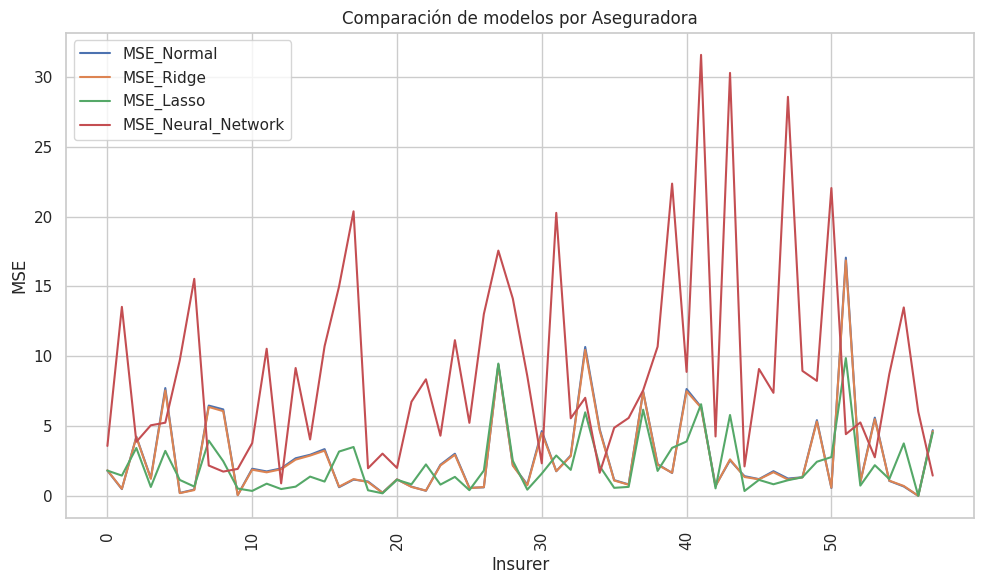

In [ ]:
# Gráfico de comparación
plt.figure(figsize=(10, 6))

for modelo in ['MSE_Normal', 'MSE_Ridge', 'MSE_Lasso', 'MSE_Neural_Network']:
    plt.plot(range(len(resultado_lrm['Insurer'])), resultado_lrm[modelo], label=modelo)  # Gráfico de línea para cada columna

# Configuración del gráfico
plt.xlabel('Insurer')  # Nombre del eje x
plt.ylabel('MSE')  # Nombre del eje y
plt.title('Comparación de modelos por Aseguradora')  # Título del gráfico
plt.xticks(rotation=90)  # Rotación de las etiquetas en el eje x para mejor visualización
plt.legend()  # Mostrar leyenda con los nombres de las columnas
plt.grid(True)  # Mostrar cuadrícula

# Mostrar el gráfico
plt.tight_layout()
plt.show()

El modelo con el mejor desempeño es el modelo de regresión con el ajuste de regularización de Lasso

Comportamiento de la métrica de desempeño MSE para el experimento con regresión lineal:


<function matplotlib.pyplot.show(close=None, block=None)>

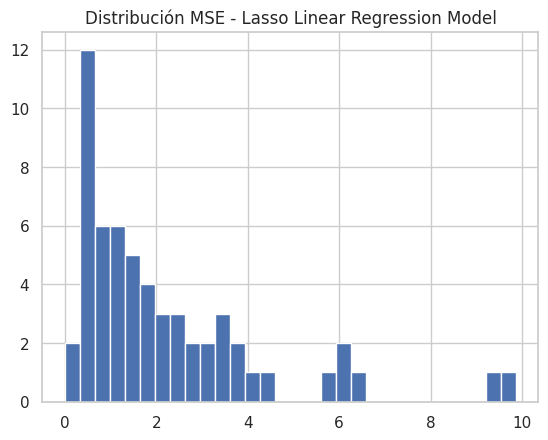

In [ ]:
print('Comportamiento de la métrica de desempeño MSE para el experimento con regresión lineal:')
plt.hist(resultado_lrm['MSE_Lasso'],30)
plt.title("Distribución MSE - Lasso Linear Regression Model")
plt.show

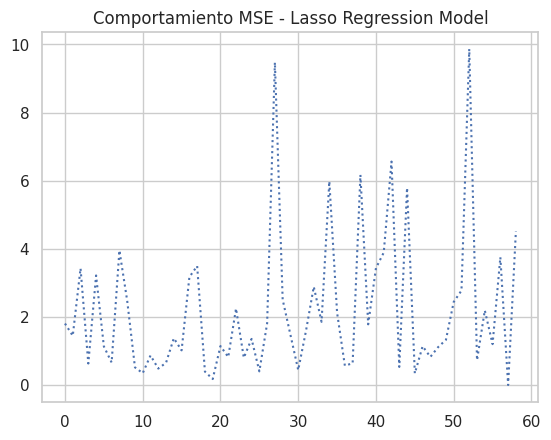

In [ ]:
plt.plot(resultado_lrm['MSE_Lasso'], linestyle = 'dotted')
plt.title('Comportamiento MSE - Lasso Regression Model')
plt.show()

In [ ]:
modelo_final, mse_final = Lasso_regression_model_function(37370, 0.001)
parameters = round(pd.DataFrame(np.exp(modelo_final.coef_)).T,2)
parameters.columns = name_parameters
print(f'El mejor modelo es la regresión de Lasso con un MSE {mse_final:.3f}%',
      '\ny parámetros: ')
parameters.index = ['Parámetro']
parameters

El mejor modelo es la regresión de Lasso con un MSE 2.195% 
y parámetros: 


,u,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,b_2,b_3,b_4,b_5,b_6,b_7,b_8,b_9,b_10
Parámetro,1.0,1.27,1.37,0.73,1.22,1.24,1.34,1.31,1.13,1.03,1.94,2.95,3.98,5.08,6.22,7.42,8.6,9.67,9.88


## 5.- Evaluación de modelo

### 5.1. Comparación entre el modelo actual y el propuesto

In [ ]:
round(resultado_lrm.describe().drop('count').T.drop(['Insurer', 'MSE_Normal', 'MSE_Ridge', 'MSE_Neural_Network']),3)

,mean,std,min,25%,50%,75%,max
MSE_ChainLadder,9.605,7.072,0.000,4.476,8.690,12.118,38.539
MSE_Lasso,2.214,2.142,0.004,0.681,1.413,3.101,9.867


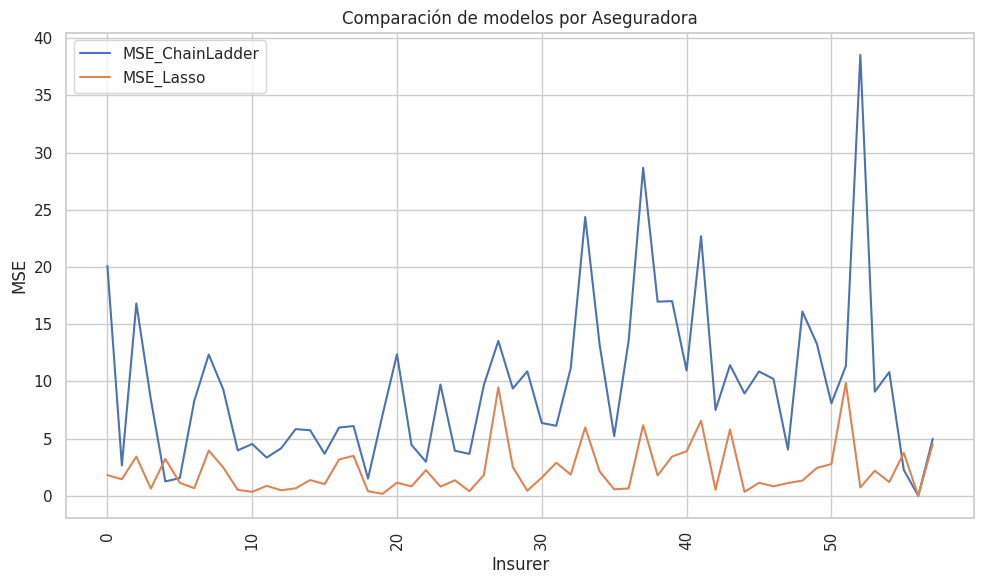

In [ ]:
# Gráfico de comparación
plt.figure(figsize=(10, 6))

for modelo in ['MSE_ChainLadder','MSE_Lasso']:
    plt.plot(range(len(resultado_lrm['Insurer'])), resultado_lrm[modelo], label=modelo)  # Gráfico de línea para cada columna

# Configuración del gráfico
plt.xlabel('Insurer')  # Nombre del eje x
plt.ylabel('MSE')  # Nombre del eje y
plt.title('Comparación de modelos por Aseguradora')  # Título del gráfico
plt.xticks(rotation=90)  # Rotación de las etiquetas en el eje x para mejor visualización
plt.legend()  # Mostrar leyenda con los nombres de las columnas
plt.grid(True)  # Mostrar cuadrícula

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### 5.2. Impacto de los resultados

#### 5.2.1. Reservas

In [ ]:
# resumen de las reservas de la industria
reservas = data[(data['AccidentYear']==1997)&
 (data['DevelopmentYear']==2006)][['GRCODE', 'GRNAME','Single','PostedReserve97_D']]

# estadísticas reservas industria
industria = pd.DataFrame(reservas['PostedReserve97_D'].describe())
industria.columns = ['Total Industria']

# estadísticas reservas aseguradoras independientes
independientes = pd.DataFrame(reservas[reservas['Single']==1]['PostedReserve97_D'].describe())
independientes.columns = ['Independientes']

# estadísticas reservas aseguradoras de conglomerado
conglomerados = pd.DataFrame(reservas[reservas['Single']==0]['PostedReserve97_D'].describe())
conglomerados.columns = ['Conglomerados']

In [ ]:
# Consolidado reservas
reservas_resumen = conglomerados.T
reservas_resumen = reservas_resumen.append(independientes.T)
reservas_resumen = reservas_resumen.append(industria.T)
reservas_resumen = round(reservas_resumen,0)
reservas_resumen

,count,mean,std,min,25%,50%,75%,max
Conglomerados,36.0,107217.0,234225.0,0.0,1956.0,14486.0,51727.0,1090093.0
Independientes,96.0,14401.0,30680.0,0.0,276.0,1945.0,10477.0,203128.0
Total Industria,132.0,39714.0,130621.0,0.0,411.0,2732.0,19266.0,1090093.0


In [ ]:
mse_propuesto = 2.214 # modelo propuesto Regresión Lasso
mse_actual = 9.605 # modelo actual Chain Ladder Determinístico
impacto = reservas_resumen[['count', 'mean']] # reservas promedio
impacto['Error actual'] = round(impacto['mean']*(mse_actual/100),0) # error actual
impacto['Error propuesto'] = round(impacto['mean']*(mse_propuesto/100),0) # error modelo propuesto
impacto['Mejora monto'] = impacto['Error actual']-impacto['Error propuesto'] # Mejora en precisión
impacto['Mejora %'] = round(impacto['Mejora monto']/impacto['mean']*100,3) # proporción de mejora
impacto.rename(columns={'mean': 'Reserva promedio', 'count':'Compañias'}, inplace=True)
impacto[['Reserva promedio', 'Error actual', 'Error propuesto', 'Mejora %']]

,Reserva promedio,Error actual,Error propuesto,Mejora %
Conglomerados,107217.0,10298.0,2374.0,7.391
Independientes,14401.0,1383.0,319.0,7.388
Total Industria,39714.0,3815.0,879.0,7.393
